#### Uploading packages and data

In [1]:
import pandas as pd
import numpy as np
import re
from pymystem3 import Mystem
import emoji
import string
import nltk
from collections import Counter
from gensim.models import word2vec
import gensim.corpora as corpora
import gensim
import regex
import logging
import json
import codecs
import glob
from tqdm import tqdm
from gensim.test.utils import datapath

In [2]:
def remove_emoji(text):
    import emoji
    import re
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in list(emoji.UNICODE_EMOJI.keys())]
    clean_text = re.sub("|".join(emoji_list), "", text)
    return clean_text

In [3]:
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [4]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Message %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [5]:
def message_wordlist(text, remove_stopwords=False):
    words = text.lower().split()
    return(words)

In [6]:
data_all = pd.read_csv('/olgasilyutina/emoji_prediction/data/df.csv')

/Users/o.silutina/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
m = Mystem()
texts_lem = []
for i in range(len(data_all['texts'])):
    lemmas = m.lemmatize(data_all['texts'][i])
    texts_lem.append(''.join(lemmas))
data_all['texts_lem'] = texts_lem

In [ ]:
clean_texts = []
for i in tqdm(range(len(data_all['texts_lem']))):
    #removing punctuation
    text = data_all['texts_lem'][i]
    translator = str.maketrans('', '', string.punctuation + '...')
    text = ' '.join(re.sub(r"(http\S+)|(RT)|(\@\w+)|(\#\w+)", " ", text).split())
    text = remove_emoji(text)
    text = text.translate(translator)
    clean_texts.append(text)
data_all['clean_text'] = clean_texts

#### Train test split

In [6]:
data_all = pd.read_csv('/olgasilyutina/emoji_prediction/rf_classifier/data_with_clean_text_emo.csv')

/Users/o.silutina/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
feat = pd.read_csv('/olgasilyutina/emoji_prediction/rf_classifier/text_features.csv')
data_all['id'] = data_all.reset_index()['index']+1
data_all = data_all.merge(feat, on=['id'])

In [9]:
data_all.drop('names', axis=1).head(1)

,texts,time,channel,source,emoji,texts_lem,clean_text,id,n_urls,n_hashtags,...,w190,w191,w192,w193,w194,w195,w196,w197,w198,w199
0,😎,16.10.2018 10:40:46,msk24,Telegram,😎,😎\n,NaN,1,-0.35007,-0.152488,...,-0.027354,-0.027367,-0.027258,-0.02372,-0.038695,-0.02347,-0.030952,-0.029692,-0.04129,-0.035299


In [10]:
np.random.seed(0) ; np.random.rand(4)
msk = np.random.rand(len(data_all)) < 0.90
train = data_all[msk]
test = data_all[~msk]

In [11]:
train = train.reset_index().drop(['index'], axis=1)
test = test.reset_index().drop(['index'], axis=1)

In [12]:
sentences = []
for i in tqdm(range(len(train['clean_text']))):
    sentences.append(nltk.word_tokenize(str(train['clean_text'][i])))

100%|██████████| 337230/337230 [00:55<00:00, 6094.28it/s]


In [143]:
len(sentences)

337230

In [13]:
flat_sentences = [item for sublist in sentences for item in sublist]
words_count = Counter(flat_sentences)
words_count = pd.DataFrame.from_dict(words_count, orient='index').reset_index()

In [14]:
words_count.columns = ['word', 'count']
words_count.sort_values(['count'], ascending=False).head(2)
words_count.to_csv('words_count.csv', index=False)

#### Create word2vec embeddings for sentiment analysis

In [15]:
# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 1 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10       # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

In [ ]:
print("Training model....")
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "100features_1minword_10context"
model.save(model_name)

In [ ]:
# check for the case
model.wv.similar_by_word("плохой")

In [ ]:
clean_train_texts = []
for text in train['clean_text']:
    clean_train_texts.append(message_wordlist(text, remove_stopwords=False))

In [ ]:
# trainDataVecs = getAvgFeatureVecs(sentences, model, num_features)

In [ ]:
# get input file for socialsent
words_count.columns = ['lem_word', 'count']
words = []
vectors = []
for word in tqdm(words_count['lem_word']):
    words.append(word)
    vectors.append(list(model[word]))

In [ ]:
# save word2vec output to txt file
data_vect = pd.DataFrame(vectors, columns=list(range(100)))
data_vect.index = words
data_vect['lem_word'] = words
data_vect = data_vect.drop('lem_word', axis=1).reset_index()
data_vect.to_csv(r'data_emo.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
# file with russian sentiment dictionary 
rusentilex = pd.read_csv('/olgasilyutina/emoji_prediction/rf_classifier/rusentilex_2017.csv')
rusentilex = rusentilex.drop_duplicates()
rusentilex['sentiment'] = np.where(rusentilex['sentiment'] == 'positive/negative', 'neutral', rusentilex['sentiment'])
rusentilex['sentiment_bin'] = np.where(rusentilex['sentiment'] == 'positive', 1, \
                                       np.where(rusentilex['sentiment'] == 'negative', -1, 0))
dic_sen = pd.Series(rusentilex.sentiment_bin.values,index=rusentilex.lem_word).to_dict()

with codecs.open('/olgasilyutina/emoji_prediction/rf_classifier/dic_sent.json', 'w', "utf-8") as fp:
    json.dump(dic_sen, fp, ensure_ascii=False)

**Note: sentiment prediction is in forked socialsent repository (https://github.com/williamleif/socialsent)**

#### LDA model

In [15]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [16]:
len(train)

337230

In [17]:
texts = []
for i in tqdm(range(len(train['clean_text']))):
    text = train['clean_text'][i]
    texts.append(nltk.word_tokenize(str(text)))

100%|██████████| 337230/337230 [00:59<00:00, 5712.62it/s]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [19]:
# Set up log to external log file
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Build LDA model
lda_model_emo = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=1,
                                           alpha=0.001,
                                           per_word_topics=True,
                                           minimum_probability=0)

In [20]:
# Save model to disk. /Users/o.silutina/anaconda3/lib/python3.6/site-packages/gensim/test/test_data
temp_file = datapath("lda_fin_train_model")
lda_model_emo.save(temp_file)
# lda_model_emo = gensim.models.ldamodel.LdaModel.load(temp_file)

In [54]:
def get_topics_for_docs(corpus, k, clean_texts):
    '''get most probable topics for corpus documents'''
    docs_train_ids = []
    topics_train = []
    for i in tqdm(list(range(len(corpus)))):
        seen_doc = corpus[i]
        vector = lda_model_emo[seen_doc]
        probs = []
        for t in list(range(k)):
            probs.append(vector[0][t][1])
        docs_train_ids.append(i)
        topics_train.append(probs.index(max(probs)))
    df_topics = pd.DataFrame({'clean_text': clean_texts, 'topic': topics_train})
    return df_topics

In [55]:
train_topics = get_topics_for_docs(corpus, 20, train['clean_text'])



  0%|          | 0/337230 [00:00<?, ?it/s]

  0%|          | 12/337230 [00:00<48:09, 116.71it/s]

  0%|          | 27/337230 [00:00<45:14, 124.23it/s]

  0%|          | 43/337230 [00:00<42:13, 133.07it/s]

  0%|          | 57/337230 [00:00<41:53, 134.15it/s]

  0%|          | 74/337230 [00:00<39:27, 142.40it/s]

  0%|          | 89/337230 [00:00<38:54, 144.44it/s]

  0%|          | 105/337230 [00:00<37:57, 148.06it/s]

  0%|          | 123/337230 [00:00<36:20, 154.64it/s]

  0%|          | 138/337230 [00:00<37:03, 151.64it/s]

  0%|          | 153/337230 [00:01<46:20, 121.21it/s]

  0%|          | 166/337230 [00:01<1:04:36, 86.96it/s]

  0%|          | 177/337230 [00:01<1:05:07, 86.25it/s]

  0%|          | 187/337230 [00:01<1:06:34, 84.37it/s]

  0%|          | 199/337230 [00:01<1:01:07, 91.89it/s]

  0%|          | 210/337230 [00:01<58:10, 96.54it/s]  

  0%|          | 223/337230 [00:01<53:52, 104.25it/s]

  0%|          | 239/337230 [00:02<48:28, 115.86it/s]

  0%|          | 255

  2%|▏         | 5220/337230 [00:29<22:41, 243.83it/s]

  2%|▏         | 5245/337230 [00:30<22:49, 242.48it/s]

  2%|▏         | 5270/337230 [00:30<22:50, 242.30it/s]

  2%|▏         | 5296/337230 [00:30<22:31, 245.69it/s]

  2%|▏         | 5321/337230 [00:30<22:35, 244.89it/s]

  2%|▏         | 5347/337230 [00:30<22:18, 247.88it/s]

  2%|▏         | 5372/337230 [00:30<22:20, 247.63it/s]

  2%|▏         | 5398/337230 [00:30<22:06, 250.22it/s]

  2%|▏         | 5424/337230 [00:30<22:38, 244.22it/s]

  2%|▏         | 5449/337230 [00:30<22:39, 244.10it/s]

  2%|▏         | 5474/337230 [00:31<23:28, 235.56it/s]

  2%|▏         | 5499/337230 [00:31<23:13, 238.02it/s]

  2%|▏         | 5523/337230 [00:31<23:17, 237.39it/s]

  2%|▏         | 5548/337230 [00:31<23:10, 238.45it/s]

  2%|▏         | 5573/337230 [00:31<22:56, 240.87it/s]

  2%|▏         | 5598/337230 [00:31<22:53, 241.46it/s]

  2%|▏         | 5624/337230 [00:31<22:30, 245.57it/s]

  2%|▏         | 5650/337230 [00:31<22:19, 247.4

  3%|▎         | 11339/337230 [00:58<23:52, 227.50it/s]

  3%|▎         | 11364/337230 [00:58<23:17, 233.22it/s]

  3%|▎         | 11389/337230 [00:58<23:02, 235.68it/s]

  3%|▎         | 11413/337230 [00:58<22:56, 236.76it/s]

  3%|▎         | 11438/337230 [00:58<22:38, 239.74it/s]

  3%|▎         | 11463/337230 [00:58<23:45, 228.46it/s]

  3%|▎         | 11486/337230 [00:58<30:47, 176.29it/s]

  3%|▎         | 11508/337230 [00:58<29:14, 185.68it/s]

  3%|▎         | 11532/337230 [00:59<27:22, 198.24it/s]

  3%|▎         | 11557/337230 [00:59<25:54, 209.54it/s]

  3%|▎         | 11580/337230 [00:59<25:18, 214.45it/s]

  3%|▎         | 11604/337230 [00:59<24:41, 219.80it/s]

  3%|▎         | 11627/337230 [00:59<25:20, 214.19it/s]

  3%|▎         | 11649/337230 [00:59<25:24, 213.56it/s]

  3%|▎         | 11672/337230 [00:59<24:55, 217.63it/s]

  3%|▎         | 11695/337230 [00:59<24:31, 221.18it/s]

  3%|▎         | 11718/337230 [00:59<24:21, 222.76it/s]

  3%|▎         | 11742/337230 [

  5%|▍         | 16547/337230 [01:28<29:42, 179.87it/s]

  5%|▍         | 16570/337230 [01:28<27:46, 192.45it/s]

  5%|▍         | 16590/337230 [01:28<30:03, 177.83it/s]

  5%|▍         | 16610/337230 [01:28<29:22, 181.95it/s]

  5%|▍         | 16629/337230 [01:28<29:32, 180.83it/s]

  5%|▍         | 16648/337230 [01:28<32:14, 165.69it/s]

  5%|▍         | 16666/337230 [01:28<32:10, 166.09it/s]

  5%|▍         | 16685/337230 [01:28<31:00, 172.26it/s]

  5%|▍         | 16707/337230 [01:29<29:05, 183.65it/s]

  5%|▍         | 16732/337230 [01:29<26:57, 198.12it/s]

  5%|▍         | 16754/337230 [01:29<26:14, 203.53it/s]

  5%|▍         | 16775/337230 [01:29<29:18, 182.21it/s]

  5%|▍         | 16800/337230 [01:29<27:02, 197.51it/s]

  5%|▍         | 16826/337230 [01:29<25:11, 211.92it/s]

  5%|▍         | 16849/337230 [01:29<25:05, 212.80it/s]

  5%|▌         | 16871/337230 [01:29<25:35, 208.66it/s]

  5%|▌         | 16896/337230 [01:29<24:28, 218.08it/s]

  5%|▌         | 16920/337230 [

  7%|▋         | 22171/337230 [01:57<53:10, 98.74it/s] 

  7%|▋         | 22183/337230 [01:57<53:27, 98.22it/s]

  7%|▋         | 22202/337230 [01:57<45:59, 114.17it/s]

  7%|▋         | 22224/337230 [01:57<39:27, 133.03it/s]

  7%|▋         | 22245/337230 [01:57<35:57, 146.02it/s]

  7%|▋         | 22262/337230 [01:57<35:42, 147.04it/s]

  7%|▋         | 22279/337230 [01:58<41:57, 125.12it/s]

  7%|▋         | 22294/337230 [01:58<42:30, 123.47it/s]

  7%|▋         | 22308/337230 [01:58<46:55, 111.84it/s]

  7%|▋         | 22326/337230 [01:58<42:00, 124.94it/s]

  7%|▋         | 22343/337230 [01:58<38:46, 135.37it/s]

  7%|▋         | 22358/337230 [01:58<40:02, 131.05it/s]

  7%|▋         | 22373/337230 [01:58<38:32, 136.17it/s]

  7%|▋         | 22388/337230 [01:58<37:54, 138.40it/s]

  7%|▋         | 22403/337230 [01:58<39:21, 133.33it/s]

  7%|▋         | 22417/337230 [01:59<39:17, 133.55it/s]

  7%|▋         | 22431/337230 [01:59<41:32, 126.31it/s]

  7%|▋         | 22446/337230 [0

  8%|▊         | 28075/337230 [02:25<23:23, 220.34it/s]

  8%|▊         | 28098/337230 [02:25<23:12, 221.95it/s]

  8%|▊         | 28121/337230 [02:26<23:07, 222.84it/s]

  8%|▊         | 28146/337230 [02:26<22:24, 229.80it/s]

  8%|▊         | 28170/337230 [02:26<22:18, 230.95it/s]

  8%|▊         | 28194/337230 [02:26<23:38, 217.90it/s]

  8%|▊         | 28219/337230 [02:26<22:52, 225.07it/s]

  8%|▊         | 28243/337230 [02:26<22:32, 228.39it/s]

  8%|▊         | 28267/337230 [02:26<22:13, 231.69it/s]

  8%|▊         | 28292/337230 [02:26<22:01, 233.85it/s]

  8%|▊         | 28316/337230 [02:26<22:01, 233.76it/s]

  8%|▊         | 28341/337230 [02:26<21:50, 235.70it/s]

  8%|▊         | 28365/337230 [02:27<21:54, 234.93it/s]

  8%|▊         | 28389/337230 [02:27<22:13, 231.52it/s]

  8%|▊         | 28413/337230 [02:27<22:04, 233.11it/s]

  8%|▊         | 28437/337230 [02:27<22:02, 233.49it/s]

  8%|▊         | 28461/337230 [02:27<22:11, 231.86it/s]

  8%|▊         | 28485/337230 [

 10%|▉         | 33314/337230 [02:56<32:27, 156.05it/s]

 10%|▉         | 33336/337230 [02:56<29:50, 169.75it/s]

 10%|▉         | 33358/337230 [02:56<28:03, 180.51it/s]

 10%|▉         | 33377/337230 [02:56<28:14, 179.30it/s]

 10%|▉         | 33396/337230 [02:56<29:19, 172.67it/s]

 10%|▉         | 33419/337230 [02:56<27:24, 184.69it/s]

 10%|▉         | 33440/337230 [02:56<26:25, 191.58it/s]

 10%|▉         | 33462/337230 [02:56<25:30, 198.49it/s]

 10%|▉         | 33484/337230 [02:57<25:06, 201.68it/s]

 10%|▉         | 33505/337230 [02:57<25:36, 197.68it/s]

 10%|▉         | 33525/337230 [02:57<25:44, 196.65it/s]

 10%|▉         | 33547/337230 [02:57<25:03, 202.02it/s]

 10%|▉         | 33568/337230 [02:57<24:50, 203.69it/s]

 10%|▉         | 33589/337230 [02:57<28:02, 180.42it/s]

 10%|▉         | 33609/337230 [02:57<27:27, 184.33it/s]

 10%|▉         | 33629/337230 [02:57<27:14, 185.72it/s]

 10%|▉         | 33648/337230 [02:57<27:21, 184.91it/s]

 10%|▉         | 33670/337230 [

 11%|█▏        | 38558/337230 [03:26<29:46, 167.23it/s]

 11%|█▏        | 38576/337230 [03:26<30:06, 165.34it/s]

 11%|█▏        | 38595/337230 [03:26<29:19, 169.73it/s]

 11%|█▏        | 38615/337230 [03:26<28:12, 176.46it/s]

 11%|█▏        | 38634/337230 [03:26<27:53, 178.47it/s]

 11%|█▏        | 38653/337230 [03:26<34:22, 144.78it/s]

 11%|█▏        | 38669/337230 [03:26<38:25, 129.50it/s]

 11%|█▏        | 38686/337230 [03:27<36:01, 138.14it/s]

 11%|█▏        | 38702/337230 [03:27<34:53, 142.61it/s]

 11%|█▏        | 38721/337230 [03:27<32:22, 153.66it/s]

 11%|█▏        | 38740/337230 [03:27<30:39, 162.31it/s]

 11%|█▏        | 38759/337230 [03:27<29:24, 169.16it/s]

 11%|█▏        | 38778/337230 [03:27<28:47, 172.81it/s]

 12%|█▏        | 38799/337230 [03:27<27:25, 181.37it/s]

 12%|█▏        | 38818/337230 [03:27<27:35, 180.26it/s]

 12%|█▏        | 38839/337230 [03:27<26:30, 187.63it/s]

 12%|█▏        | 38860/337230 [03:27<25:47, 192.83it/s]

 12%|█▏        | 38880/337230 [

 13%|█▎        | 43635/337230 [03:56<33:10, 147.47it/s]

 13%|█▎        | 43656/337230 [03:56<30:24, 160.95it/s]

 13%|█▎        | 43675/337230 [03:56<29:06, 168.09it/s]

 13%|█▎        | 43698/337230 [03:56<27:02, 180.88it/s]

 13%|█▎        | 43719/337230 [03:56<26:12, 186.67it/s]

 13%|█▎        | 43739/337230 [03:56<25:42, 190.24it/s]

 13%|█▎        | 43759/337230 [03:57<29:41, 164.69it/s]

 13%|█▎        | 43783/337230 [03:57<27:08, 180.23it/s]

 13%|█▎        | 43807/337230 [03:57<25:18, 193.21it/s]

 13%|█▎        | 43828/337230 [03:57<26:30, 184.52it/s]

 13%|█▎        | 43848/337230 [03:57<27:23, 178.49it/s]

 13%|█▎        | 43869/337230 [03:57<26:15, 186.19it/s]

 13%|█▎        | 43889/337230 [03:57<30:08, 162.23it/s]

 13%|█▎        | 43907/337230 [03:57<32:35, 149.98it/s]

 13%|█▎        | 43923/337230 [03:58<32:19, 151.21it/s]

 13%|█▎        | 43942/337230 [03:58<30:32, 160.05it/s]

 13%|█▎        | 43959/337230 [03:58<32:29, 150.42it/s]

 13%|█▎        | 43975/337230 [

 14%|█▍        | 48698/337230 [04:26<24:44, 194.33it/s]

 14%|█▍        | 48718/337230 [04:26<29:33, 162.72it/s]

 14%|█▍        | 48736/337230 [04:26<45:14, 106.29it/s]

 14%|█▍        | 48750/337230 [04:27<59:15, 81.12it/s] 

 14%|█▍        | 48762/337230 [04:27<1:10:20, 68.36it/s]

 14%|█▍        | 48772/337230 [04:27<1:11:51, 66.91it/s]

 14%|█▍        | 48791/337230 [04:27<58:06, 82.74it/s]  

 14%|█▍        | 48815/337230 [04:27<46:49, 102.65it/s]

 14%|█▍        | 48840/337230 [04:27<38:39, 124.31it/s]

 14%|█▍        | 48863/337230 [04:27<33:23, 143.94it/s]

 14%|█▍        | 48883/337230 [04:27<30:57, 155.27it/s]

 15%|█▍        | 48907/337230 [04:28<27:54, 172.23it/s]

 15%|█▍        | 48931/337230 [04:28<25:34, 187.92it/s]

 15%|█▍        | 48956/337230 [04:28<23:45, 202.18it/s]

 15%|█▍        | 48979/337230 [04:28<23:21, 205.65it/s]

 15%|█▍        | 49003/337230 [04:28<22:33, 213.02it/s]

 15%|█▍        | 49026/337230 [04:28<28:09, 170.54it/s]

 15%|█▍        | 49046/33723

 15%|█▌        | 51309/337230 [04:41<22:49, 208.75it/s]

 15%|█▌        | 51332/337230 [04:41<22:23, 212.78it/s]

 15%|█▌        | 51354/337230 [04:41<22:20, 213.34it/s]

 15%|█▌        | 51376/337230 [04:42<29:12, 163.13it/s]

 15%|█▌        | 51395/337230 [04:42<28:58, 164.40it/s]

 15%|█▌        | 51413/337230 [04:42<28:35, 166.58it/s]

 15%|█▌        | 51431/337230 [04:42<29:29, 161.49it/s]

 15%|█▌        | 51448/337230 [04:42<33:48, 140.87it/s]

 15%|█▌        | 51464/337230 [04:42<37:43, 126.27it/s]

 15%|█▌        | 51478/337230 [04:42<39:31, 120.48it/s]

 15%|█▌        | 51491/337230 [04:43<40:36, 117.25it/s]

 15%|█▌        | 51509/337230 [04:43<36:30, 130.44it/s]

 15%|█▌        | 51533/337230 [04:43<31:40, 150.33it/s]

 15%|█▌        | 51554/337230 [04:43<29:17, 162.53it/s]

 15%|█▌        | 51575/337230 [04:43<27:32, 172.83it/s]

 15%|█▌        | 51595/337230 [04:43<26:39, 178.61it/s]

 15%|█▌        | 51614/337230 [04:43<28:23, 167.67it/s]

 15%|█▌        | 51635/337230 [

 17%|█▋        | 56570/337230 [05:12<24:42, 189.25it/s]

 17%|█▋        | 56592/337230 [05:12<23:50, 196.16it/s]

 17%|█▋        | 56613/337230 [05:12<23:28, 199.24it/s]

 17%|█▋        | 56636/337230 [05:12<22:46, 205.37it/s]

 17%|█▋        | 56657/337230 [05:12<23:16, 200.87it/s]

 17%|█▋        | 56678/337230 [05:12<23:04, 202.62it/s]

 17%|█▋        | 56699/337230 [05:12<23:01, 203.08it/s]

 17%|█▋        | 56720/337230 [05:12<24:26, 191.31it/s]

 17%|█▋        | 56740/337230 [05:12<24:54, 187.67it/s]

 17%|█▋        | 56762/337230 [05:13<24:03, 194.30it/s]

 17%|█▋        | 56784/337230 [05:13<23:29, 198.98it/s]

 17%|█▋        | 56805/337230 [05:13<25:30, 183.27it/s]

 17%|█▋        | 56824/337230 [05:13<26:05, 179.14it/s]

 17%|█▋        | 56843/337230 [05:13<25:54, 180.33it/s]

 17%|█▋        | 56862/337230 [05:13<25:44, 181.48it/s]

 17%|█▋        | 56881/337230 [05:13<26:32, 176.02it/s]

 17%|█▋        | 56899/337230 [05:13<32:32, 143.59it/s]

 17%|█▋        | 56916/337230 [

 18%|█▊        | 61620/337230 [05:42<31:33, 145.55it/s]

 18%|█▊        | 61639/337230 [05:42<29:35, 155.23it/s]

 18%|█▊        | 61660/337230 [05:42<27:31, 166.90it/s]

 18%|█▊        | 61678/337230 [05:42<26:59, 170.11it/s]

 18%|█▊        | 61697/337230 [05:42<26:15, 174.91it/s]

 18%|█▊        | 61717/337230 [05:42<25:18, 181.48it/s]

 18%|█▊        | 61738/337230 [05:42<24:19, 188.73it/s]

 18%|█▊        | 61758/337230 [05:43<24:41, 186.00it/s]

 18%|█▊        | 61779/337230 [05:43<23:55, 191.90it/s]

 18%|█▊        | 61799/337230 [05:43<24:28, 187.55it/s]

 18%|█▊        | 61818/337230 [05:43<24:23, 188.16it/s]

 18%|█▊        | 61837/337230 [05:43<24:45, 185.34it/s]

 18%|█▊        | 61856/337230 [05:43<25:11, 182.13it/s]

 18%|█▊        | 61875/337230 [05:43<25:53, 177.22it/s]

 18%|█▊        | 61897/337230 [05:43<24:31, 187.17it/s]

 18%|█▊        | 61919/337230 [05:44<27:39, 165.88it/s]

 18%|█▊        | 61937/337230 [05:44<29:45, 154.16it/s]

 18%|█▊        | 61954/337230 [

 19%|█▉        | 64272/337230 [05:58<29:54, 152.11it/s]

 19%|█▉        | 64289/337230 [05:58<29:55, 152.00it/s]

 19%|█▉        | 64305/337230 [05:58<29:34, 153.80it/s]

 19%|█▉        | 64322/337230 [05:58<28:45, 158.14it/s]

 19%|█▉        | 64342/337230 [05:58<26:58, 168.59it/s]

 19%|█▉        | 64360/337230 [05:58<28:54, 157.33it/s]

 19%|█▉        | 64377/337230 [05:59<35:32, 127.97it/s]

 19%|█▉        | 64392/337230 [05:59<34:34, 131.53it/s]

 19%|█▉        | 64408/337230 [05:59<33:05, 137.40it/s]

 19%|█▉        | 64428/337230 [05:59<30:09, 150.78it/s]

 19%|█▉        | 64448/337230 [05:59<27:55, 162.80it/s]

 19%|█▉        | 64468/337230 [05:59<26:28, 171.70it/s]

 19%|█▉        | 64488/337230 [05:59<25:32, 177.98it/s]

 19%|█▉        | 64509/337230 [05:59<24:31, 185.32it/s]

 19%|█▉        | 64533/337230 [05:59<23:01, 197.41it/s]

 19%|█▉        | 64558/337230 [05:59<21:43, 209.11it/s]

 19%|█▉        | 64580/337230 [06:00<21:46, 208.65it/s]

 19%|█▉        | 64602/337230 [

 21%|██        | 69454/337230 [06:28<23:12, 192.27it/s]

 21%|██        | 69474/337230 [06:28<26:28, 168.54it/s]

 21%|██        | 69495/337230 [06:28<25:01, 178.34it/s]

 21%|██        | 69515/337230 [06:28<24:19, 183.39it/s]

 21%|██        | 69534/337230 [06:28<25:08, 177.43it/s]

 21%|██        | 69555/337230 [06:28<24:14, 184.03it/s]

 21%|██        | 69579/337230 [06:28<22:44, 196.09it/s]

 21%|██        | 69604/337230 [06:28<21:25, 208.18it/s]

 21%|██        | 69626/337230 [06:29<29:04, 153.41it/s]

 21%|██        | 69644/337230 [06:29<29:48, 149.65it/s]

 21%|██        | 69662/337230 [06:29<28:30, 156.40it/s]

 21%|██        | 69679/337230 [06:29<29:05, 153.30it/s]

 21%|██        | 69696/337230 [06:29<35:33, 125.42it/s]

 21%|██        | 69711/337230 [06:29<38:53, 114.63it/s]

 21%|██        | 69725/337230 [06:29<36:55, 120.75it/s]

 21%|██        | 69746/337230 [06:29<32:20, 137.83it/s]

 21%|██        | 69762/337230 [06:30<32:30, 137.14it/s]

 21%|██        | 69777/337230 [

 22%|██▏       | 74461/337230 [06:58<21:45, 201.25it/s]

 22%|██▏       | 74483/337230 [06:58<21:24, 204.62it/s]

 22%|██▏       | 74506/337230 [06:58<20:47, 210.54it/s]

 22%|██▏       | 74530/337230 [06:58<20:03, 218.23it/s]

 22%|██▏       | 74553/337230 [06:58<19:58, 219.16it/s]

 22%|██▏       | 74576/337230 [06:59<19:50, 220.69it/s]

 22%|██▏       | 74600/337230 [06:59<19:31, 224.10it/s]

 22%|██▏       | 74624/337230 [06:59<19:15, 227.27it/s]

 22%|██▏       | 74647/337230 [06:59<19:15, 227.27it/s]

 22%|██▏       | 74671/337230 [06:59<19:06, 228.94it/s]

 22%|██▏       | 74694/337230 [06:59<19:15, 227.24it/s]

 22%|██▏       | 74717/337230 [06:59<19:20, 226.14it/s]

 22%|██▏       | 74741/337230 [06:59<19:11, 228.01it/s]

 22%|██▏       | 74765/337230 [06:59<18:58, 230.49it/s]

 22%|██▏       | 74789/337230 [06:59<19:01, 229.88it/s]

 22%|██▏       | 74813/337230 [07:00<20:07, 217.39it/s]

 22%|██▏       | 74836/337230 [07:00<19:58, 218.90it/s]

 22%|██▏       | 74860/337230 [

 24%|██▍       | 80360/337230 [07:26<19:53, 215.30it/s]

 24%|██▍       | 80382/337230 [07:26<19:55, 214.85it/s]

 24%|██▍       | 80404/337230 [07:26<19:52, 215.35it/s]

 24%|██▍       | 80428/337230 [07:26<19:28, 219.70it/s]

 24%|██▍       | 80451/337230 [07:26<19:43, 216.94it/s]

 24%|██▍       | 80474/337230 [07:26<19:32, 218.93it/s]

 24%|██▍       | 80496/337230 [07:26<19:59, 213.97it/s]

 24%|██▍       | 80518/337230 [07:26<20:04, 213.22it/s]

 24%|██▍       | 80541/337230 [07:26<19:47, 216.16it/s]

 24%|██▍       | 80564/337230 [07:26<19:35, 218.29it/s]

 24%|██▍       | 80587/337230 [07:27<19:30, 219.17it/s]

 24%|██▍       | 80611/337230 [07:27<19:05, 224.00it/s]

 24%|██▍       | 80634/337230 [07:27<19:25, 220.21it/s]

 24%|██▍       | 80657/337230 [07:27<19:17, 221.62it/s]

 24%|██▍       | 80680/337230 [07:27<19:53, 214.98it/s]

 24%|██▍       | 80702/337230 [07:27<19:53, 214.88it/s]

 24%|██▍       | 80725/337230 [07:27<19:32, 218.69it/s]

 24%|██▍       | 80747/337230 [

 26%|██▌       | 86234/337230 [07:54<18:38, 224.49it/s]

 26%|██▌       | 86258/337230 [07:54<18:18, 228.41it/s]

 26%|██▌       | 86283/337230 [07:54<17:55, 233.28it/s]

 26%|██▌       | 86307/337230 [07:54<18:49, 222.25it/s]

 26%|██▌       | 86330/337230 [07:54<18:37, 224.47it/s]

 26%|██▌       | 86353/337230 [07:54<18:38, 224.22it/s]

 26%|██▌       | 86376/337230 [07:54<18:40, 223.81it/s]

 26%|██▌       | 86399/337230 [07:55<18:51, 221.69it/s]

 26%|██▌       | 86422/337230 [07:55<19:03, 219.30it/s]

 26%|██▌       | 86446/337230 [07:55<18:37, 224.40it/s]

 26%|██▌       | 86471/337230 [07:55<18:11, 229.63it/s]

 26%|██▌       | 86495/337230 [07:55<18:07, 230.64it/s]

 26%|██▌       | 86519/337230 [07:55<18:12, 229.52it/s]

 26%|██▌       | 86542/337230 [07:55<18:25, 226.77it/s]

 26%|██▌       | 86566/337230 [07:55<18:11, 229.68it/s]

 26%|██▌       | 86590/337230 [07:55<18:09, 229.97it/s]

 26%|██▌       | 86614/337230 [07:55<17:58, 232.37it/s]

 26%|██▌       | 86638/337230 [

 27%|██▋       | 92162/337230 [08:21<21:02, 194.11it/s]

 27%|██▋       | 92183/337230 [08:21<20:50, 195.94it/s]

 27%|██▋       | 92203/337230 [08:21<20:48, 196.21it/s]

 27%|██▋       | 92223/337230 [08:22<24:36, 165.94it/s]

 27%|██▋       | 92241/337230 [08:22<24:22, 167.47it/s]

 27%|██▋       | 92262/337230 [08:22<23:03, 177.03it/s]

 27%|██▋       | 92282/337230 [08:22<22:20, 182.70it/s]

 27%|██▋       | 92305/337230 [08:22<21:10, 192.84it/s]

 27%|██▋       | 92327/337230 [08:22<20:35, 198.21it/s]

 27%|██▋       | 92349/337230 [08:22<20:09, 202.42it/s]

 27%|██▋       | 92372/337230 [08:22<19:28, 209.56it/s]

 27%|██▋       | 92395/337230 [08:22<19:07, 213.35it/s]

 27%|██▋       | 92417/337230 [08:23<19:05, 213.63it/s]

 27%|██▋       | 92439/337230 [08:23<19:17, 211.51it/s]

 27%|██▋       | 92462/337230 [08:23<18:53, 215.95it/s]

 27%|██▋       | 92485/337230 [08:23<18:42, 218.01it/s]

 27%|██▋       | 92510/337230 [08:23<18:08, 224.91it/s]

 27%|██▋       | 92535/337230 [

 29%|██▉       | 97293/337230 [08:50<25:18, 157.98it/s]

 29%|██▉       | 97309/337230 [08:50<26:24, 151.43it/s]

 29%|██▉       | 97325/337230 [08:50<27:29, 145.45it/s]

 29%|██▉       | 97341/337230 [08:50<27:20, 146.27it/s]

 29%|██▉       | 97356/337230 [08:51<29:18, 136.42it/s]

 29%|██▉       | 97372/337230 [08:51<28:05, 142.33it/s]

 29%|██▉       | 97387/337230 [08:51<28:44, 139.08it/s]

 29%|██▉       | 97403/337230 [08:51<27:58, 142.84it/s]

 29%|██▉       | 97418/337230 [08:51<27:41, 144.37it/s]

 29%|██▉       | 97433/337230 [08:51<27:25, 145.73it/s]

 29%|██▉       | 97449/337230 [08:51<26:45, 149.39it/s]

 29%|██▉       | 97465/337230 [08:51<26:32, 150.55it/s]

 29%|██▉       | 97481/337230 [08:51<27:27, 145.49it/s]

 29%|██▉       | 97496/337230 [08:52<29:49, 133.96it/s]

 29%|██▉       | 97510/337230 [08:52<29:31, 135.36it/s]

 29%|██▉       | 97524/337230 [08:52<30:05, 132.75it/s]

 29%|██▉       | 97540/337230 [08:52<28:41, 139.19it/s]

 29%|██▉       | 97556/337230 [

 30%|███       | 102492/337230 [09:19<19:39, 199.08it/s]

 30%|███       | 102513/337230 [09:19<21:06, 185.38it/s]

 30%|███       | 102532/337230 [09:19<21:28, 182.13it/s]

 30%|███       | 102551/337230 [09:19<22:54, 170.76it/s]

 30%|███       | 102573/337230 [09:20<21:22, 183.02it/s]

 30%|███       | 102593/337230 [09:20<20:51, 187.44it/s]

 30%|███       | 102613/337230 [09:20<25:10, 155.31it/s]

 30%|███       | 102630/337230 [09:20<28:29, 137.25it/s]

 30%|███       | 102647/337230 [09:20<26:59, 144.88it/s]

 30%|███       | 102665/337230 [09:20<26:08, 149.53it/s]

 30%|███       | 102681/337230 [09:20<32:45, 119.36it/s]

 30%|███       | 102702/337230 [09:20<28:32, 136.93it/s]

 30%|███       | 102723/337230 [09:21<25:43, 151.89it/s]

 30%|███       | 102743/337230 [09:21<24:04, 162.28it/s]

 30%|███       | 102761/337230 [09:21<25:00, 156.30it/s]

 30%|███       | 102778/337230 [09:21<30:31, 128.04it/s]

 30%|███       | 102797/337230 [09:21<27:33, 141.74it/s]

 30%|███      

 32%|███▏      | 107370/337230 [09:50<26:17, 145.74it/s]

 32%|███▏      | 107392/337230 [09:50<23:41, 161.70it/s]

 32%|███▏      | 107411/337230 [09:50<22:49, 167.84it/s]

 32%|███▏      | 107429/337230 [09:50<23:05, 165.92it/s]

 32%|███▏      | 107450/337230 [09:50<21:49, 175.42it/s]

 32%|███▏      | 107473/337230 [09:50<20:23, 187.85it/s]

 32%|███▏      | 107494/337230 [09:50<19:56, 191.94it/s]

 32%|███▏      | 107516/337230 [09:50<19:20, 197.98it/s]

 32%|███▏      | 107537/337230 [09:51<19:24, 197.26it/s]

 32%|███▏      | 107557/337230 [09:51<19:29, 196.36it/s]

 32%|███▏      | 107578/337230 [09:51<19:26, 196.92it/s]

 32%|███▏      | 107598/337230 [09:51<19:41, 194.30it/s]

 32%|███▏      | 107619/337230 [09:51<19:21, 197.62it/s]

 32%|███▏      | 107641/337230 [09:51<18:57, 201.91it/s]

 32%|███▏      | 107665/337230 [09:51<18:09, 210.73it/s]

 32%|███▏      | 107689/337230 [09:51<17:40, 216.40it/s]

 32%|███▏      | 107711/337230 [09:51<24:01, 159.20it/s]

 32%|███▏     

 33%|███▎      | 112724/337230 [10:19<17:24, 215.00it/s]

 33%|███▎      | 112747/337230 [10:19<17:14, 217.06it/s]

 33%|███▎      | 112772/337230 [10:19<16:40, 224.29it/s]

 33%|███▎      | 112795/337230 [10:19<16:41, 224.02it/s]

 33%|███▎      | 112818/337230 [10:19<16:46, 222.91it/s]

 33%|███▎      | 112842/337230 [10:19<16:36, 225.27it/s]

 33%|███▎      | 112865/337230 [10:19<16:37, 225.01it/s]

 33%|███▎      | 112890/337230 [10:19<16:17, 229.53it/s]

 33%|███▎      | 112913/337230 [10:19<16:21, 228.56it/s]

 33%|███▎      | 112936/337230 [10:19<16:33, 225.70it/s]

 33%|███▎      | 112960/337230 [10:20<16:21, 228.52it/s]

 34%|███▎      | 112983/337230 [10:20<17:03, 219.10it/s]

 34%|███▎      | 113006/337230 [10:20<17:04, 218.84it/s]

 34%|███▎      | 113028/337230 [10:20<17:12, 217.14it/s]

 34%|███▎      | 113052/337230 [10:20<16:53, 221.19it/s]

 34%|███▎      | 113075/337230 [10:20<27:59, 133.45it/s]

 34%|███▎      | 113093/337230 [10:21<36:44, 101.69it/s]

 34%|███▎     

 35%|███▌      | 118050/337230 [10:47<17:42, 206.34it/s]

 35%|███▌      | 118071/337230 [10:47<17:49, 204.99it/s]

 35%|███▌      | 118093/337230 [10:47<17:30, 208.55it/s]

 35%|███▌      | 118114/337230 [10:48<17:33, 208.08it/s]

 35%|███▌      | 118135/337230 [10:48<17:53, 204.13it/s]

 35%|███▌      | 118157/337230 [10:48<17:41, 206.30it/s]

 35%|███▌      | 118178/337230 [10:48<18:33, 196.66it/s]

 35%|███▌      | 118198/337230 [10:48<19:28, 187.49it/s]

 35%|███▌      | 118217/337230 [10:48<21:19, 171.15it/s]

 35%|███▌      | 118235/337230 [10:48<22:59, 158.72it/s]

 35%|███▌      | 118252/337230 [10:48<25:22, 143.79it/s]

 35%|███▌      | 118272/337230 [10:49<23:26, 155.69it/s]

 35%|███▌      | 118294/337230 [10:49<21:31, 169.56it/s]

 35%|███▌      | 118312/337230 [10:49<21:17, 171.32it/s]

 35%|███▌      | 118333/337230 [10:49<20:14, 180.26it/s]

 35%|███▌      | 118353/337230 [10:49<19:53, 183.32it/s]

 35%|███▌      | 118373/337230 [10:49<19:27, 187.47it/s]

 35%|███▌     

 37%|███▋      | 123423/337230 [11:16<19:54, 179.00it/s]

 37%|███▋      | 123443/337230 [11:16<19:30, 182.71it/s]

 37%|███▋      | 123464/337230 [11:16<18:49, 189.28it/s]

 37%|███▋      | 123487/337230 [11:16<18:02, 197.52it/s]

 37%|███▋      | 123508/337230 [11:16<18:00, 197.83it/s]

 37%|███▋      | 123529/337230 [11:16<18:06, 196.70it/s]

 37%|███▋      | 123549/337230 [11:16<18:19, 194.27it/s]

 37%|███▋      | 123571/337230 [11:16<17:43, 200.83it/s]

 37%|███▋      | 123592/337230 [11:16<17:57, 198.22it/s]

 37%|███▋      | 123612/337230 [11:17<18:53, 188.47it/s]

 37%|███▋      | 123632/337230 [11:17<18:48, 189.28it/s]

 37%|███▋      | 123657/337230 [11:17<17:33, 202.70it/s]

 37%|███▋      | 123679/337230 [11:17<17:11, 207.02it/s]

 37%|███▋      | 123700/337230 [11:17<21:45, 163.60it/s]

 37%|███▋      | 123720/337230 [11:17<20:36, 172.72it/s]

 37%|███▋      | 123741/337230 [11:17<19:58, 178.12it/s]

 37%|███▋      | 123760/337230 [11:17<21:03, 168.90it/s]

 37%|███▋     

 38%|███▊      | 128550/337230 [11:45<19:06, 182.05it/s]

 38%|███▊      | 128572/337230 [11:45<18:16, 190.33it/s]

 38%|███▊      | 128594/337230 [11:45<17:38, 197.06it/s]

 38%|███▊      | 128615/337230 [11:45<17:26, 199.41it/s]

 38%|███▊      | 128638/337230 [11:45<16:51, 206.13it/s]

 38%|███▊      | 128662/337230 [11:45<16:19, 212.93it/s]

 38%|███▊      | 128686/337230 [11:45<15:52, 218.99it/s]

 38%|███▊      | 128709/337230 [11:45<22:20, 155.52it/s]

 38%|███▊      | 128728/337230 [11:46<23:22, 148.71it/s]

 38%|███▊      | 128746/337230 [11:46<22:12, 156.42it/s]

 38%|███▊      | 128764/337230 [11:46<24:35, 141.33it/s]

 38%|███▊      | 128780/337230 [11:46<31:19, 110.91it/s]

 38%|███▊      | 128794/337230 [11:46<41:55, 82.85it/s] 

 38%|███▊      | 128806/337230 [11:46<38:10, 91.01it/s]

 38%|███▊      | 128818/337230 [11:47<37:04, 93.71it/s]

 38%|███▊      | 128834/337230 [11:47<32:30, 106.85it/s]

 38%|███▊      | 128856/337230 [11:47<27:29, 126.30it/s]

 38%|███▊      |

 40%|███▉      | 133350/337230 [12:14<19:31, 174.05it/s]

 40%|███▉      | 133373/337230 [12:14<18:16, 185.98it/s]

 40%|███▉      | 133395/337230 [12:14<17:35, 193.18it/s]

 40%|███▉      | 133416/337230 [12:14<17:14, 197.00it/s]

 40%|███▉      | 133437/337230 [12:15<20:46, 163.50it/s]

 40%|███▉      | 133455/337230 [12:15<21:17, 159.50it/s]

 40%|███▉      | 133474/337230 [12:15<20:42, 163.92it/s]

 40%|███▉      | 133492/337230 [12:15<25:16, 134.36it/s]

 40%|███▉      | 133507/337230 [12:15<24:52, 136.50it/s]

 40%|███▉      | 133522/337230 [12:15<25:38, 132.39it/s]

 40%|███▉      | 133540/337230 [12:15<23:50, 142.36it/s]

 40%|███▉      | 133562/337230 [12:15<21:28, 158.11it/s]

 40%|███▉      | 133584/337230 [12:16<19:41, 172.39it/s]

 40%|███▉      | 133603/337230 [12:16<20:49, 163.00it/s]

 40%|███▉      | 133622/337230 [12:16<20:19, 166.89it/s]

 40%|███▉      | 133646/337230 [12:16<18:36, 182.40it/s]

 40%|███▉      | 133668/337230 [12:16<17:44, 191.17it/s]

 40%|███▉     

 41%|████      | 138410/337230 [12:44<19:12, 172.56it/s]

 41%|████      | 138428/337230 [12:44<23:02, 143.81it/s]

 41%|████      | 138445/337230 [12:44<22:05, 149.99it/s]

 41%|████      | 138461/337230 [12:44<22:16, 148.74it/s]

 41%|████      | 138477/337230 [12:44<21:55, 151.13it/s]

 41%|████      | 138493/337230 [12:44<24:50, 133.35it/s]

 41%|████      | 138508/337230 [12:44<27:44, 119.40it/s]

 41%|████      | 138521/337230 [12:45<27:53, 118.74it/s]

 41%|████      | 138534/337230 [12:45<28:35, 115.79it/s]

 41%|████      | 138551/337230 [12:45<26:01, 127.24it/s]

 41%|████      | 138565/337230 [12:45<25:54, 127.76it/s]

 41%|████      | 138582/337230 [12:45<24:15, 136.44it/s]

 41%|████      | 138600/337230 [12:45<22:41, 145.88it/s]

 41%|████      | 138617/337230 [12:45<21:56, 150.87it/s]

 41%|████      | 138633/337230 [12:45<23:10, 142.87it/s]

 41%|████      | 138654/337230 [12:45<20:58, 157.80it/s]

 41%|████      | 138673/337230 [12:46<20:01, 165.30it/s]

 41%|████     

 43%|████▎     | 143863/337230 [13:12<16:00, 201.38it/s]

 43%|████▎     | 143884/337230 [13:12<15:49, 203.60it/s]

 43%|████▎     | 143905/337230 [13:12<17:35, 183.11it/s]

 43%|████▎     | 143924/337230 [13:12<19:16, 167.13it/s]

 43%|████▎     | 143943/337230 [13:12<18:43, 172.05it/s]

 43%|████▎     | 143964/337230 [13:12<17:45, 181.31it/s]

 43%|████▎     | 143987/337230 [13:12<16:44, 192.31it/s]

 43%|████▎     | 144008/337230 [13:13<16:37, 193.71it/s]

 43%|████▎     | 144028/337230 [13:13<22:08, 145.45it/s]

 43%|████▎     | 144045/337230 [13:13<23:12, 138.73it/s]

 43%|████▎     | 144061/337230 [13:13<24:01, 133.98it/s]

 43%|████▎     | 144076/337230 [13:13<24:27, 131.67it/s]

 43%|████▎     | 144090/337230 [13:13<24:03, 133.85it/s]

 43%|████▎     | 144115/337230 [13:13<20:48, 154.64it/s]

 43%|████▎     | 144138/337230 [13:13<18:54, 170.20it/s]

 43%|████▎     | 144162/337230 [13:14<17:16, 186.20it/s]

 43%|████▎     | 144185/337230 [13:14<16:21, 196.62it/s]

 43%|████▎    

 44%|████▍     | 148998/337230 [13:41<15:36, 200.94it/s]

 44%|████▍     | 149019/337230 [13:41<16:37, 188.70it/s]

 44%|████▍     | 149042/337230 [13:42<15:44, 199.32it/s]

 44%|████▍     | 149065/337230 [13:42<15:07, 207.32it/s]

 44%|████▍     | 149087/337230 [13:42<15:38, 200.39it/s]

 44%|████▍     | 149112/337230 [13:42<14:47, 211.98it/s]

 44%|████▍     | 149136/337230 [13:42<14:22, 218.03it/s]

 44%|████▍     | 149161/337230 [13:42<13:50, 226.50it/s]

 44%|████▍     | 149184/337230 [13:42<14:21, 218.36it/s]

 44%|████▍     | 149210/337230 [13:42<13:46, 227.55it/s]

 44%|████▍     | 149234/337230 [13:42<16:39, 188.05it/s]

 44%|████▍     | 149255/337230 [13:43<22:15, 140.73it/s]

 44%|████▍     | 149272/337230 [13:43<22:58, 136.37it/s]

 44%|████▍     | 149288/337230 [13:43<22:42, 137.92it/s]

 44%|████▍     | 149304/337230 [13:43<25:17, 123.88it/s]

 44%|████▍     | 149318/337230 [13:43<27:21, 114.47it/s]

 44%|████▍     | 149331/337230 [13:43<26:36, 117.70it/s]

 44%|████▍    

 46%|████▌     | 154334/337230 [14:10<15:18, 199.05it/s]

 46%|████▌     | 154354/337230 [14:10<16:08, 188.82it/s]

 46%|████▌     | 154374/337230 [14:10<15:56, 191.26it/s]

 46%|████▌     | 154394/337230 [14:10<15:51, 192.20it/s]

 46%|████▌     | 154414/337230 [14:10<17:20, 175.65it/s]

 46%|████▌     | 154432/337230 [14:10<19:45, 154.20it/s]

 46%|████▌     | 154450/337230 [14:11<18:57, 160.70it/s]

 46%|████▌     | 154467/337230 [14:11<19:06, 159.38it/s]

 46%|████▌     | 154488/337230 [14:11<17:50, 170.67it/s]

 46%|████▌     | 154508/337230 [14:11<17:15, 176.51it/s]

 46%|████▌     | 154529/337230 [14:11<16:26, 185.23it/s]

 46%|████▌     | 154551/337230 [14:11<15:43, 193.61it/s]

 46%|████▌     | 154571/337230 [14:11<15:51, 192.02it/s]

 46%|████▌     | 154592/337230 [14:11<15:29, 196.51it/s]

 46%|████▌     | 154612/337230 [14:11<17:09, 177.38it/s]

 46%|████▌     | 154631/337230 [14:11<17:01, 178.80it/s]

 46%|████▌     | 154652/337230 [14:12<16:20, 186.26it/s]

 46%|████▌    

 47%|████▋     | 159370/337230 [14:38<15:19, 193.34it/s]

 47%|████▋     | 159390/337230 [14:38<15:47, 187.65it/s]

 47%|████▋     | 159409/337230 [14:38<16:05, 184.24it/s]

 47%|████▋     | 159428/337230 [14:38<16:01, 184.94it/s]

 47%|████▋     | 159447/337230 [14:38<15:57, 185.65it/s]

 47%|████▋     | 159466/337230 [14:38<15:55, 186.07it/s]

 47%|████▋     | 159486/337230 [14:39<15:38, 189.30it/s]

 47%|████▋     | 159506/337230 [14:39<15:31, 190.78it/s]

 47%|████▋     | 159526/337230 [14:39<15:26, 191.75it/s]

 47%|████▋     | 159546/337230 [14:39<15:20, 192.98it/s]

 47%|████▋     | 159566/337230 [14:39<16:31, 179.14it/s]

 47%|████▋     | 159588/337230 [14:39<15:37, 189.58it/s]

 47%|████▋     | 159610/337230 [14:39<15:07, 195.81it/s]

 47%|████▋     | 159630/337230 [14:39<15:10, 195.02it/s]

 47%|████▋     | 159650/337230 [14:39<16:24, 180.29it/s]

 47%|████▋     | 159673/337230 [14:40<15:24, 191.96it/s]

 47%|████▋     | 159696/337230 [14:40<14:43, 200.87it/s]

 47%|████▋    

 49%|████▉     | 164860/337230 [15:06<13:58, 205.58it/s]

 49%|████▉     | 164882/337230 [15:06<13:50, 207.62it/s]

 49%|████▉     | 164903/337230 [15:06<15:06, 190.06it/s]

 49%|████▉     | 164923/337230 [15:06<16:08, 177.96it/s]

 49%|████▉     | 164943/337230 [15:06<15:41, 183.08it/s]

 49%|████▉     | 164962/337230 [15:06<16:04, 178.55it/s]

 49%|████▉     | 164981/337230 [15:06<16:38, 172.48it/s]

 49%|████▉     | 164999/337230 [15:06<16:40, 172.10it/s]

 49%|████▉     | 165017/337230 [15:06<17:24, 164.87it/s]

 49%|████▉     | 165035/337230 [15:07<17:02, 168.41it/s]

 49%|████▉     | 165057/337230 [15:07<15:51, 180.94it/s]

 49%|████▉     | 165077/337230 [15:07<15:27, 185.62it/s]

 49%|████▉     | 165100/337230 [15:07<14:38, 195.92it/s]

 49%|████▉     | 165122/337230 [15:07<14:15, 201.21it/s]

 49%|████▉     | 165144/337230 [15:07<13:59, 205.10it/s]

 49%|████▉     | 165165/337230 [15:07<14:16, 200.90it/s]

 49%|████▉     | 165186/337230 [15:07<15:41, 182.69it/s]

 49%|████▉    

 50%|█████     | 170014/337230 [15:40<14:38, 190.26it/s]

 50%|█████     | 170034/337230 [15:40<14:32, 191.68it/s]

 50%|█████     | 170054/337230 [15:40<14:23, 193.58it/s]

 50%|█████     | 170074/337230 [15:40<14:24, 193.46it/s]

 50%|█████     | 170094/337230 [15:40<14:17, 194.81it/s]

 50%|█████     | 170114/337230 [15:41<14:20, 194.10it/s]

 50%|█████     | 170135/337230 [15:41<14:15, 195.36it/s]

 50%|█████     | 170155/337230 [15:41<14:16, 195.02it/s]

 50%|█████     | 170176/337230 [15:41<14:02, 198.28it/s]

 50%|█████     | 170196/337230 [15:41<14:02, 198.26it/s]

 50%|█████     | 170216/337230 [15:41<14:54, 186.75it/s]

 50%|█████     | 170235/337230 [15:41<15:14, 182.71it/s]

 50%|█████     | 170256/337230 [15:41<14:45, 188.46it/s]

 50%|█████     | 170277/337230 [15:41<14:33, 191.19it/s]

 50%|█████     | 170297/337230 [15:42<14:39, 189.71it/s]

 51%|█████     | 170318/337230 [15:42<14:17, 194.69it/s]

 51%|█████     | 170338/337230 [15:42<14:12, 195.66it/s]

 51%|█████    

 52%|█████▏    | 175085/337230 [16:08<15:52, 170.27it/s]

 52%|█████▏    | 175103/337230 [16:08<17:18, 156.17it/s]

 52%|█████▏    | 175121/337230 [16:08<16:37, 162.50it/s]

 52%|█████▏    | 175141/337230 [16:08<15:43, 171.79it/s]

 52%|█████▏    | 175162/337230 [16:09<14:53, 181.36it/s]

 52%|█████▏    | 175185/337230 [16:09<14:03, 192.04it/s]

 52%|█████▏    | 175205/337230 [16:09<14:55, 180.83it/s]

 52%|█████▏    | 175226/337230 [16:09<14:24, 187.45it/s]

 52%|█████▏    | 175249/337230 [16:09<13:43, 196.71it/s]

 52%|█████▏    | 175272/337230 [16:09<13:16, 203.40it/s]

 52%|█████▏    | 175295/337230 [16:09<12:53, 209.40it/s]

 52%|█████▏    | 175318/337230 [16:09<12:33, 214.82it/s]

 52%|█████▏    | 175340/337230 [16:09<12:40, 212.89it/s]

 52%|█████▏    | 175362/337230 [16:09<13:17, 202.98it/s]

 52%|█████▏    | 175385/337230 [16:10<12:57, 208.26it/s]

 52%|█████▏    | 175408/337230 [16:10<12:36, 213.82it/s]

 52%|█████▏    | 175431/337230 [16:10<12:28, 216.19it/s]

 52%|█████▏   

 53%|█████▎    | 180303/337230 [16:37<28:57, 90.33it/s]

 53%|█████▎    | 180314/337230 [16:37<34:00, 76.92it/s]

 53%|█████▎    | 180324/337230 [16:37<33:11, 78.81it/s]

 53%|█████▎    | 180337/337230 [16:37<29:39, 88.19it/s]

 53%|█████▎    | 180349/337230 [16:37<27:53, 93.73it/s]

 53%|█████▎    | 180362/337230 [16:37<25:49, 101.22it/s]

 53%|█████▎    | 180376/337230 [16:37<23:48, 109.79it/s]

 53%|█████▎    | 180388/337230 [16:38<25:40, 101.83it/s]

 53%|█████▎    | 180399/337230 [16:38<26:28, 98.72it/s] 

 53%|█████▎    | 180415/337230 [16:38<23:33, 110.97it/s]

 54%|█████▎    | 180435/337230 [16:38<20:34, 127.00it/s]

 54%|█████▎    | 180457/337230 [16:38<18:03, 144.64it/s]

 54%|█████▎    | 180479/337230 [16:38<16:15, 160.61it/s]

 54%|█████▎    | 180501/337230 [16:38<15:04, 173.36it/s]

 54%|█████▎    | 180520/337230 [16:38<14:42, 177.53it/s]

 54%|█████▎    | 180539/337230 [16:38<15:40, 166.56it/s]

 54%|█████▎    | 180557/337230 [16:39<16:00, 163.10it/s]

 54%|█████▎    | 18

 55%|█████▍    | 184426/337230 [17:05<15:38, 162.77it/s]

 55%|█████▍    | 184443/337230 [17:05<15:29, 164.43it/s]

 55%|█████▍    | 184462/337230 [17:05<14:53, 171.02it/s]

 55%|█████▍    | 184480/337230 [17:06<15:22, 165.58it/s]

 55%|█████▍    | 184500/337230 [17:06<14:43, 172.96it/s]

 55%|█████▍    | 184518/337230 [17:06<16:27, 154.62it/s]

 55%|█████▍    | 184534/337230 [17:06<16:48, 151.43it/s]

 55%|█████▍    | 184553/337230 [17:06<15:54, 159.95it/s]

 55%|█████▍    | 184572/337230 [17:06<15:16, 166.54it/s]

 55%|█████▍    | 184592/337230 [17:06<14:39, 173.55it/s]

 55%|█████▍    | 184610/337230 [17:06<14:33, 174.75it/s]

 55%|█████▍    | 184628/337230 [17:06<15:05, 168.48it/s]

 55%|█████▍    | 184646/337230 [17:07<16:55, 150.26it/s]

 55%|█████▍    | 184662/337230 [17:07<20:12, 125.81it/s]

 55%|█████▍    | 184676/337230 [17:07<22:40, 112.11it/s]

 55%|█████▍    | 184689/337230 [17:07<23:51, 106.56it/s]

 55%|█████▍    | 184706/337230 [17:07<21:22, 118.97it/s]

 55%|█████▍   

 56%|█████▋    | 189753/337230 [17:33<11:12, 219.32it/s]

 56%|█████▋    | 189775/337230 [17:33<11:37, 211.25it/s]

 56%|█████▋    | 189797/337230 [17:34<11:31, 213.35it/s]

 56%|█████▋    | 189819/337230 [17:34<11:52, 206.92it/s]

 56%|█████▋    | 189840/337230 [17:34<11:53, 206.51it/s]

 56%|█████▋    | 189862/337230 [17:34<11:42, 209.84it/s]

 56%|█████▋    | 189885/337230 [17:34<11:31, 213.18it/s]

 56%|█████▋    | 189907/337230 [17:34<11:28, 214.02it/s]

 56%|█████▋    | 189929/337230 [17:34<12:44, 192.74it/s]

 56%|█████▋    | 189949/337230 [17:34<13:31, 181.46it/s]

 56%|█████▋    | 189970/337230 [17:34<13:06, 187.15it/s]

 56%|█████▋    | 189991/337230 [17:35<12:44, 192.69it/s]

 56%|█████▋    | 190013/337230 [17:35<12:21, 198.51it/s]

 56%|█████▋    | 190034/337230 [17:35<13:42, 179.02it/s]

 56%|█████▋    | 190053/337230 [17:35<14:36, 167.96it/s]

 56%|█████▋    | 190071/337230 [17:35<15:00, 163.33it/s]

 56%|█████▋    | 190088/337230 [17:35<15:16, 160.50it/s]

 56%|█████▋   

 58%|█████▊    | 195351/337230 [18:01<10:51, 217.66it/s]

 58%|█████▊    | 195373/337230 [18:01<10:52, 217.33it/s]

 58%|█████▊    | 195397/337230 [18:01<10:38, 221.99it/s]

 58%|█████▊    | 195421/337230 [18:01<10:30, 224.79it/s]

 58%|█████▊    | 195444/337230 [18:01<10:30, 224.98it/s]

 58%|█████▊    | 195467/337230 [18:01<10:26, 226.31it/s]

 58%|█████▊    | 195490/337230 [18:01<10:41, 220.96it/s]

 58%|█████▊    | 195513/337230 [18:02<10:46, 219.19it/s]

 58%|█████▊    | 195535/337230 [18:02<11:14, 210.08it/s]

 58%|█████▊    | 195558/337230 [18:02<11:03, 213.51it/s]

 58%|█████▊    | 195581/337230 [18:02<10:52, 217.00it/s]

 58%|█████▊    | 195604/337230 [18:02<10:46, 219.03it/s]

 58%|█████▊    | 195627/337230 [18:02<10:37, 222.10it/s]

 58%|█████▊    | 195650/337230 [18:02<10:31, 224.37it/s]

 58%|█████▊    | 195674/337230 [18:02<10:25, 226.42it/s]

 58%|█████▊    | 195697/337230 [18:02<10:34, 222.94it/s]

 58%|█████▊    | 195720/337230 [18:02<10:51, 217.08it/s]

 58%|█████▊   

 59%|█████▉    | 200644/337230 [18:29<10:04, 226.05it/s]

 60%|█████▉    | 200667/337230 [18:29<10:10, 223.87it/s]

 60%|█████▉    | 200690/337230 [18:29<10:06, 225.16it/s]

 60%|█████▉    | 200713/337230 [18:29<10:06, 225.25it/s]

 60%|█████▉    | 200736/337230 [18:29<10:09, 223.93it/s]

 60%|█████▉    | 200759/337230 [18:30<10:41, 212.70it/s]

 60%|█████▉    | 200781/337230 [18:30<10:36, 214.41it/s]

 60%|█████▉    | 200803/337230 [18:30<10:37, 213.85it/s]

 60%|█████▉    | 200827/337230 [18:30<10:22, 219.03it/s]

 60%|█████▉    | 200850/337230 [18:30<10:17, 220.76it/s]

 60%|█████▉    | 200874/337230 [18:30<10:07, 224.51it/s]

 60%|█████▉    | 200898/337230 [18:30<10:00, 227.11it/s]

 60%|█████▉    | 200922/337230 [18:30<09:52, 230.21it/s]

 60%|█████▉    | 200946/337230 [18:30<10:04, 225.41it/s]

 60%|█████▉    | 200969/337230 [18:30<10:15, 221.47it/s]

 60%|█████▉    | 200992/337230 [18:31<10:34, 214.76it/s]

 60%|█████▉    | 201014/337230 [18:31<10:34, 214.80it/s]

 60%|█████▉   

 61%|██████    | 206278/337230 [18:56<10:58, 198.92it/s]

 61%|██████    | 206299/337230 [18:57<11:55, 183.01it/s]

 61%|██████    | 206318/337230 [18:57<12:09, 179.38it/s]

 61%|██████    | 206341/337230 [18:57<11:25, 190.95it/s]

 61%|██████    | 206363/337230 [18:57<10:58, 198.67it/s]

 61%|██████    | 206385/337230 [18:57<10:41, 204.08it/s]

 61%|██████    | 206408/337230 [18:57<10:25, 209.07it/s]

 61%|██████    | 206431/337230 [18:57<10:16, 212.28it/s]

 61%|██████    | 206453/337230 [18:57<10:44, 202.96it/s]

 61%|██████    | 206474/337230 [18:57<10:42, 203.48it/s]

 61%|██████    | 206496/337230 [18:58<10:33, 206.51it/s]

 61%|██████    | 206518/337230 [18:58<10:27, 208.20it/s]

 61%|██████    | 206541/337230 [18:58<10:15, 212.17it/s]

 61%|██████▏   | 206564/337230 [18:58<10:05, 215.83it/s]

 61%|██████▏   | 206587/337230 [18:58<09:56, 219.05it/s]

 61%|██████▏   | 206610/337230 [18:58<09:48, 222.13it/s]

 61%|██████▏   | 206633/337230 [18:58<09:43, 223.91it/s]

 61%|██████▏  

 63%|██████▎   | 211704/337230 [19:24<10:56, 191.33it/s]

 63%|██████▎   | 211724/337230 [19:24<10:53, 191.94it/s]

 63%|██████▎   | 211746/337230 [19:24<10:33, 198.04it/s]

 63%|██████▎   | 211766/337230 [19:24<10:39, 196.26it/s]

 63%|██████▎   | 211786/337230 [19:24<10:41, 195.55it/s]

 63%|██████▎   | 211806/337230 [19:25<10:50, 192.93it/s]

 63%|██████▎   | 211826/337230 [19:25<10:51, 192.35it/s]

 63%|██████▎   | 211847/337230 [19:25<10:38, 196.50it/s]

 63%|██████▎   | 211870/337230 [19:25<10:15, 203.65it/s]

 63%|██████▎   | 211891/337230 [19:25<10:12, 204.77it/s]

 63%|██████▎   | 211914/337230 [19:25<09:52, 211.64it/s]

 63%|██████▎   | 211937/337230 [19:25<09:40, 215.89it/s]

 63%|██████▎   | 211960/337230 [19:25<09:31, 219.07it/s]

 63%|██████▎   | 211982/337230 [19:25<10:16, 203.17it/s]

 63%|██████▎   | 212004/337230 [19:26<10:07, 206.16it/s]

 63%|██████▎   | 212025/337230 [19:26<10:05, 206.63it/s]

 63%|██████▎   | 212047/337230 [19:26<09:56, 210.03it/s]

 63%|██████▎  

 64%|██████▍   | 216989/337230 [19:52<11:42, 171.10it/s]

 64%|██████▍   | 217011/337230 [19:52<11:01, 181.70it/s]

 64%|██████▍   | 217030/337230 [19:53<12:05, 165.63it/s]

 64%|██████▍   | 217048/337230 [19:53<13:46, 145.38it/s]

 64%|██████▍   | 217066/337230 [19:53<13:05, 152.89it/s]

 64%|██████▍   | 217087/337230 [19:53<12:08, 164.90it/s]

 64%|██████▍   | 217107/337230 [19:53<11:30, 173.95it/s]

 64%|██████▍   | 217126/337230 [19:53<13:30, 148.23it/s]

 64%|██████▍   | 217142/337230 [19:53<14:52, 134.50it/s]

 64%|██████▍   | 217157/337230 [19:54<15:43, 127.30it/s]

 64%|██████▍   | 217171/337230 [19:54<16:17, 122.85it/s]

 64%|██████▍   | 217184/337230 [19:54<16:41, 119.90it/s]

 64%|██████▍   | 217197/337230 [19:54<16:28, 121.47it/s]

 64%|██████▍   | 217212/337230 [19:54<15:32, 128.73it/s]

 64%|██████▍   | 217226/337230 [19:54<18:52, 105.95it/s]

 64%|██████▍   | 217247/337230 [19:54<16:08, 123.90it/s]

 64%|██████▍   | 217267/337230 [19:54<14:19, 139.65it/s]

 64%|██████▍  

 66%|██████▌   | 222156/337230 [20:20<12:18, 155.72it/s]

 66%|██████▌   | 222176/337230 [20:20<11:39, 164.54it/s]

 66%|██████▌   | 222195/337230 [20:20<11:21, 168.84it/s]

 66%|██████▌   | 222213/337230 [20:21<11:51, 161.66it/s]

 66%|██████▌   | 222230/337230 [20:21<13:10, 145.43it/s]

 66%|██████▌   | 222248/337230 [20:21<12:27, 153.84it/s]

 66%|██████▌   | 222267/337230 [20:21<11:48, 162.27it/s]

 66%|██████▌   | 222284/337230 [20:21<12:13, 156.74it/s]

 66%|██████▌   | 222301/337230 [20:21<13:05, 146.30it/s]

 66%|██████▌   | 222318/337230 [20:21<12:33, 152.52it/s]

 66%|██████▌   | 222336/337230 [20:21<12:02, 158.99it/s]

 66%|██████▌   | 222353/337230 [20:22<12:07, 157.88it/s]

 66%|██████▌   | 222374/337230 [20:22<11:16, 169.86it/s]

 66%|██████▌   | 222396/337230 [20:22<10:35, 180.83it/s]

 66%|██████▌   | 222418/337230 [20:22<10:03, 190.19it/s]

 66%|██████▌   | 222438/337230 [20:22<10:35, 180.75it/s]

 66%|██████▌   | 222457/337230 [20:22<10:52, 176.01it/s]

 66%|██████▌  

 67%|██████▋   | 226918/337230 [20:49<08:46, 209.68it/s]

 67%|██████▋   | 226940/337230 [20:49<08:54, 206.42it/s]

 67%|██████▋   | 226961/337230 [20:49<09:26, 194.51it/s]

 67%|██████▋   | 226981/337230 [20:49<09:35, 191.43it/s]

 67%|██████▋   | 227001/337230 [20:49<09:42, 189.36it/s]

 67%|██████▋   | 227021/337230 [20:49<09:53, 185.82it/s]

 67%|██████▋   | 227043/337230 [20:50<09:31, 192.96it/s]

 67%|██████▋   | 227067/337230 [20:50<09:00, 203.85it/s]

 67%|██████▋   | 227091/337230 [20:50<08:39, 211.85it/s]

 67%|██████▋   | 227113/337230 [20:50<08:50, 207.71it/s]

 67%|██████▋   | 227134/337230 [20:50<09:09, 200.21it/s]

 67%|██████▋   | 227155/337230 [20:50<09:39, 189.98it/s]

 67%|██████▋   | 227175/337230 [20:50<10:34, 173.42it/s]

 67%|██████▋   | 227193/337230 [20:50<11:15, 162.81it/s]

 67%|██████▋   | 227213/337230 [20:51<10:39, 171.98it/s]

 67%|██████▋   | 227232/337230 [20:51<10:23, 176.28it/s]

 67%|██████▋   | 227252/337230 [20:51<10:02, 182.48it/s]

 67%|██████▋  

 69%|██████▉   | 232153/337230 [21:17<08:27, 206.94it/s]

 69%|██████▉   | 232174/337230 [21:17<08:27, 207.10it/s]

 69%|██████▉   | 232196/337230 [21:17<08:20, 209.86it/s]

 69%|██████▉   | 232219/337230 [21:17<08:09, 214.69it/s]

 69%|██████▉   | 232241/337230 [21:17<08:08, 215.11it/s]

 69%|██████▉   | 232264/337230 [21:17<08:01, 217.87it/s]

 69%|██████▉   | 232286/337230 [21:17<08:12, 213.17it/s]

 69%|██████▉   | 232308/337230 [21:18<08:25, 207.37it/s]

 69%|██████▉   | 232329/337230 [21:18<08:33, 204.40it/s]

 69%|██████▉   | 232351/337230 [21:18<08:24, 207.87it/s]

 69%|██████▉   | 232373/337230 [21:18<08:22, 208.77it/s]

 69%|██████▉   | 232395/337230 [21:18<08:17, 210.66it/s]

 69%|██████▉   | 232418/337230 [21:18<08:09, 213.99it/s]

 69%|██████▉   | 232440/337230 [21:18<08:11, 213.06it/s]

 69%|██████▉   | 232462/337230 [21:18<08:12, 212.83it/s]

 69%|██████▉   | 232484/337230 [21:18<08:15, 211.48it/s]

 69%|██████▉   | 232506/337230 [21:19<08:09, 213.92it/s]

 69%|██████▉  

 70%|███████   | 237143/337230 [21:45<08:52, 187.98it/s]

 70%|███████   | 237163/337230 [21:45<08:45, 190.49it/s]

 70%|███████   | 237184/337230 [21:45<08:35, 193.94it/s]

 70%|███████   | 237204/337230 [21:45<10:23, 160.34it/s]

 70%|███████   | 237222/337230 [21:46<11:14, 148.26it/s]

 70%|███████   | 237240/337230 [21:46<10:45, 155.01it/s]

 70%|███████   | 237258/337230 [21:46<10:20, 161.07it/s]

 70%|███████   | 237279/337230 [21:46<09:40, 172.07it/s]

 70%|███████   | 237301/337230 [21:46<09:08, 182.09it/s]

 70%|███████   | 237321/337230 [21:46<08:59, 185.33it/s]

 70%|███████   | 237340/337230 [21:46<08:55, 186.40it/s]

 70%|███████   | 237361/337230 [21:46<08:41, 191.35it/s]

 70%|███████   | 237381/337230 [21:46<08:50, 188.36it/s]

 70%|███████   | 237401/337230 [21:46<09:12, 180.56it/s]

 70%|███████   | 237420/337230 [21:47<09:08, 181.86it/s]

 70%|███████   | 237441/337230 [21:47<08:53, 187.07it/s]

 70%|███████   | 237463/337230 [21:47<08:32, 194.67it/s]

 70%|███████  

 72%|███████▏  | 242222/337230 [22:13<08:11, 193.14it/s]

 72%|███████▏  | 242242/337230 [22:13<08:08, 194.37it/s]

 72%|███████▏  | 242262/337230 [22:13<08:14, 191.91it/s]

 72%|███████▏  | 242282/337230 [22:14<08:37, 183.64it/s]

 72%|███████▏  | 242301/337230 [22:14<08:46, 180.18it/s]

 72%|███████▏  | 242320/337230 [22:14<08:47, 179.95it/s]

 72%|███████▏  | 242339/337230 [22:14<08:42, 181.59it/s]

 72%|███████▏  | 242359/337230 [22:14<08:28, 186.49it/s]

 72%|███████▏  | 242378/337230 [22:14<08:31, 185.46it/s]

 72%|███████▏  | 242397/337230 [22:14<08:30, 185.79it/s]

 72%|███████▏  | 242417/337230 [22:14<08:23, 188.16it/s]

 72%|███████▏  | 242436/337230 [22:14<08:28, 186.46it/s]

 72%|███████▏  | 242456/337230 [22:14<08:20, 189.42it/s]

 72%|███████▏  | 242477/337230 [22:15<08:07, 194.45it/s]

 72%|███████▏  | 242497/337230 [22:15<08:09, 193.36it/s]

 72%|███████▏  | 242517/337230 [22:15<08:14, 191.71it/s]

 72%|███████▏  | 242537/337230 [22:15<08:19, 189.65it/s]

 72%|███████▏ 

 73%|███████▎  | 247546/337230 [22:40<07:12, 207.21it/s]

 73%|███████▎  | 247567/337230 [22:40<07:11, 208.01it/s]

 73%|███████▎  | 247588/337230 [22:40<07:09, 208.55it/s]

 73%|███████▎  | 247610/337230 [22:40<07:05, 210.45it/s]

 73%|███████▎  | 247632/337230 [22:40<07:04, 211.00it/s]

 73%|███████▎  | 247654/337230 [22:41<07:19, 204.00it/s]

 73%|███████▎  | 247676/337230 [22:41<07:15, 205.67it/s]

 73%|███████▎  | 247698/337230 [22:41<07:09, 208.47it/s]

 73%|███████▎  | 247721/337230 [22:41<07:04, 211.08it/s]

 73%|███████▎  | 247743/337230 [22:41<07:11, 207.46it/s]

 73%|███████▎  | 247764/337230 [22:41<07:10, 207.69it/s]

 73%|███████▎  | 247786/337230 [22:41<07:07, 208.98it/s]

 73%|███████▎  | 247807/337230 [22:41<07:27, 199.92it/s]

 73%|███████▎  | 247828/337230 [22:41<07:26, 200.29it/s]

 73%|███████▎  | 247849/337230 [22:42<07:24, 201.28it/s]

 74%|███████▎  | 247870/337230 [22:42<07:22, 202.11it/s]

 74%|███████▎  | 247893/337230 [22:42<07:09, 208.00it/s]

 74%|███████▎ 

 75%|███████▌  | 252953/337230 [23:07<06:59, 200.95it/s]

 75%|███████▌  | 252974/337230 [23:07<07:08, 196.82it/s]

 75%|███████▌  | 252996/337230 [23:07<06:59, 200.97it/s]

 75%|███████▌  | 253017/337230 [23:07<06:54, 203.19it/s]

 75%|███████▌  | 253038/337230 [23:07<07:02, 199.41it/s]

 75%|███████▌  | 253059/337230 [23:08<07:20, 191.26it/s]

 75%|███████▌  | 253079/337230 [23:08<07:36, 184.47it/s]

 75%|███████▌  | 253098/337230 [23:08<07:40, 182.78it/s]

 75%|███████▌  | 253117/337230 [23:08<07:46, 180.38it/s]

 75%|███████▌  | 253136/337230 [23:08<07:53, 177.60it/s]

 75%|███████▌  | 253154/337230 [23:08<07:52, 178.00it/s]

 75%|███████▌  | 253173/337230 [23:08<07:45, 180.57it/s]

 75%|███████▌  | 253193/337230 [23:08<07:34, 185.10it/s]

 75%|███████▌  | 253213/337230 [23:08<07:25, 188.69it/s]

 75%|███████▌  | 253233/337230 [23:09<07:18, 191.69it/s]

 75%|███████▌  | 253253/337230 [23:09<07:26, 187.94it/s]

 75%|███████▌  | 253273/337230 [23:09<07:19, 191.01it/s]

 75%|███████▌ 

 77%|███████▋  | 258277/337230 [23:34<06:31, 201.55it/s]

 77%|███████▋  | 258298/337230 [23:34<06:37, 198.70it/s]

 77%|███████▋  | 258319/337230 [23:35<06:35, 199.72it/s]

 77%|███████▋  | 258339/337230 [23:35<06:36, 198.90it/s]

 77%|███████▋  | 258360/337230 [23:35<06:33, 200.29it/s]

 77%|███████▋  | 258382/337230 [23:35<06:23, 205.46it/s]

 77%|███████▋  | 258404/337230 [23:35<06:17, 208.87it/s]

 77%|███████▋  | 258425/337230 [23:35<06:20, 207.14it/s]

 77%|███████▋  | 258447/337230 [23:35<06:16, 209.14it/s]

 77%|███████▋  | 258469/337230 [23:35<06:14, 210.40it/s]

 77%|███████▋  | 258492/337230 [23:35<06:08, 213.57it/s]

 77%|███████▋  | 258514/337230 [23:35<06:21, 206.28it/s]

 77%|███████▋  | 258535/337230 [23:36<06:27, 203.27it/s]

 77%|███████▋  | 258556/337230 [23:36<06:28, 202.27it/s]

 77%|███████▋  | 258578/337230 [23:36<06:20, 206.46it/s]

 77%|███████▋  | 258599/337230 [23:36<06:22, 205.54it/s]

 77%|███████▋  | 258621/337230 [23:36<06:15, 209.23it/s]

 77%|███████▋ 

 78%|███████▊  | 263554/337230 [24:02<06:01, 203.85it/s]

 78%|███████▊  | 263575/337230 [24:02<06:03, 202.63it/s]

 78%|███████▊  | 263596/337230 [24:02<06:03, 202.32it/s]

 78%|███████▊  | 263617/337230 [24:02<06:04, 202.15it/s]

 78%|███████▊  | 263638/337230 [24:02<06:06, 200.87it/s]

 78%|███████▊  | 263659/337230 [24:02<06:01, 203.30it/s]

 78%|███████▊  | 263680/337230 [24:02<06:02, 202.82it/s]

 78%|███████▊  | 263701/337230 [24:02<06:02, 202.57it/s]

 78%|███████▊  | 263722/337230 [24:03<06:00, 203.90it/s]

 78%|███████▊  | 263743/337230 [24:03<06:12, 197.52it/s]

 78%|███████▊  | 263763/337230 [24:03<06:13, 196.66it/s]

 78%|███████▊  | 263783/337230 [24:03<06:16, 195.07it/s]

 78%|███████▊  | 263804/337230 [24:03<06:10, 198.33it/s]

 78%|███████▊  | 263828/337230 [24:03<05:54, 207.20it/s]

 78%|███████▊  | 263850/337230 [24:03<05:52, 208.28it/s]

 78%|███████▊  | 263871/337230 [24:03<05:53, 207.69it/s]

 78%|███████▊  | 263892/337230 [24:03<05:57, 205.03it/s]

 78%|███████▊ 

 80%|███████▉  | 269031/337230 [24:29<05:27, 208.47it/s]

 80%|███████▉  | 269052/337230 [24:29<05:53, 193.00it/s]

 80%|███████▉  | 269072/337230 [24:29<06:22, 178.30it/s]

 80%|███████▉  | 269091/337230 [24:29<06:19, 179.42it/s]

 80%|███████▉  | 269110/337230 [24:29<06:14, 181.79it/s]

 80%|███████▉  | 269131/337230 [24:29<06:02, 187.98it/s]

 80%|███████▉  | 269152/337230 [24:29<05:54, 192.22it/s]

 80%|███████▉  | 269172/337230 [24:30<05:51, 193.51it/s]

 80%|███████▉  | 269192/337230 [24:30<05:52, 193.26it/s]

 80%|███████▉  | 269212/337230 [24:30<05:55, 191.23it/s]

 80%|███████▉  | 269232/337230 [24:30<06:08, 184.42it/s]

 80%|███████▉  | 269252/337230 [24:30<06:01, 188.02it/s]

 80%|███████▉  | 269273/337230 [24:30<05:51, 193.19it/s]

 80%|███████▉  | 269293/337230 [24:30<06:28, 174.68it/s]

 80%|███████▉  | 269311/337230 [24:30<07:06, 159.26it/s]

 80%|███████▉  | 269328/337230 [24:31<07:20, 154.06it/s]

 80%|███████▉  | 269344/337230 [24:31<07:26, 152.18it/s]

 80%|███████▉ 

 81%|████████▏ | 274343/337230 [24:57<06:16, 167.08it/s]

 81%|████████▏ | 274360/337230 [24:57<06:16, 166.94it/s]

 81%|████████▏ | 274378/337230 [24:57<06:09, 170.13it/s]

 81%|████████▏ | 274397/337230 [24:57<06:00, 174.22it/s]

 81%|████████▏ | 274418/337230 [24:57<05:46, 181.40it/s]

 81%|████████▏ | 274437/337230 [24:57<05:44, 182.15it/s]

 81%|████████▏ | 274456/337230 [24:57<05:43, 182.58it/s]

 81%|████████▏ | 274479/337230 [24:58<05:25, 192.84it/s]

 81%|████████▏ | 274501/337230 [24:58<05:13, 200.25it/s]

 81%|████████▏ | 274523/337230 [24:58<05:07, 203.70it/s]

 81%|████████▏ | 274545/337230 [24:58<05:01, 207.69it/s]

 81%|████████▏ | 274567/337230 [24:58<04:58, 209.64it/s]

 81%|████████▏ | 274590/337230 [24:58<04:51, 215.05it/s]

 81%|████████▏ | 274614/337230 [24:58<04:44, 219.94it/s]

 81%|████████▏ | 274637/337230 [24:58<04:43, 220.53it/s]

 81%|████████▏ | 274660/337230 [24:58<04:43, 220.94it/s]

 81%|████████▏ | 274683/337230 [24:59<04:49, 215.83it/s]

 81%|████████▏

 83%|████████▎ | 279805/337230 [25:24<04:38, 206.06it/s]

 83%|████████▎ | 279826/337230 [25:24<04:41, 203.64it/s]

 83%|████████▎ | 279848/337230 [25:24<04:37, 206.84it/s]

 83%|████████▎ | 279870/337230 [25:24<04:32, 210.24it/s]

 83%|████████▎ | 279893/337230 [25:25<04:27, 214.52it/s]

 83%|████████▎ | 279916/337230 [25:25<04:24, 216.59it/s]

 83%|████████▎ | 279939/337230 [25:25<04:20, 220.09it/s]

 83%|████████▎ | 279962/337230 [25:25<04:19, 220.88it/s]

 83%|████████▎ | 279985/337230 [25:25<04:21, 218.78it/s]

 83%|████████▎ | 280007/337230 [25:25<04:24, 216.34it/s]

 83%|████████▎ | 280029/337230 [25:25<04:33, 208.91it/s]

 83%|████████▎ | 280050/337230 [25:25<04:35, 207.64it/s]

 83%|████████▎ | 280071/337230 [25:25<04:38, 205.57it/s]

 83%|████████▎ | 280092/337230 [25:26<04:43, 201.55it/s]

 83%|████████▎ | 280113/337230 [25:26<05:00, 190.28it/s]

 83%|████████▎ | 280133/337230 [25:26<04:59, 190.47it/s]

 83%|████████▎ | 280153/337230 [25:26<05:00, 189.99it/s]

 83%|████████▎

 84%|████████▍ | 284848/337230 [25:52<04:04, 214.68it/s]

 84%|████████▍ | 284870/337230 [25:52<04:06, 212.48it/s]

 84%|████████▍ | 284892/337230 [25:53<04:07, 211.89it/s]

 84%|████████▍ | 284914/337230 [25:53<04:11, 208.03it/s]

 84%|████████▍ | 284935/337230 [25:53<04:14, 205.35it/s]

 84%|████████▍ | 284956/337230 [25:53<04:20, 200.76it/s]

 85%|████████▍ | 284977/337230 [25:53<04:17, 202.70it/s]

 85%|████████▍ | 284998/337230 [25:53<04:16, 203.56it/s]

 85%|████████▍ | 285020/337230 [25:53<04:14, 205.50it/s]

 85%|████████▍ | 285041/337230 [25:53<04:13, 205.99it/s]

 85%|████████▍ | 285062/337230 [25:53<04:12, 207.00it/s]

 85%|████████▍ | 285083/337230 [25:53<04:12, 206.42it/s]

 85%|████████▍ | 285104/337230 [25:54<04:12, 206.54it/s]

 85%|████████▍ | 285126/337230 [25:54<04:10, 207.60it/s]

 85%|████████▍ | 285147/337230 [25:54<04:12, 206.40it/s]

 85%|████████▍ | 285168/337230 [25:54<04:13, 205.53it/s]

 85%|████████▍ | 285189/337230 [25:54<04:13, 205.36it/s]

 85%|████████▍

 86%|████████▌ | 290455/337230 [26:20<06:50, 114.02it/s]

 86%|████████▌ | 290468/337230 [26:20<07:22, 105.78it/s]

 86%|████████▌ | 290480/337230 [26:20<07:52, 98.85it/s] 

 86%|████████▌ | 290491/337230 [26:20<09:15, 84.09it/s]

 86%|████████▌ | 290501/337230 [26:20<11:22, 68.47it/s]

 86%|████████▌ | 290513/337230 [26:20<10:00, 77.85it/s]

 86%|████████▌ | 290523/337230 [26:21<09:26, 82.48it/s]

 86%|████████▌ | 290536/337230 [26:21<08:30, 91.40it/s]

 86%|████████▌ | 290549/337230 [26:21<07:45, 100.27it/s]

 86%|████████▌ | 290561/337230 [26:21<07:29, 103.78it/s]

 86%|████████▌ | 290573/337230 [26:21<07:47, 99.84it/s] 

 86%|████████▌ | 290586/337230 [26:21<07:18, 106.29it/s]

 86%|████████▌ | 290602/337230 [26:21<06:36, 117.61it/s]

 86%|████████▌ | 290620/337230 [26:21<05:55, 131.21it/s]

 86%|████████▌ | 290638/337230 [26:21<05:28, 142.05it/s]

 86%|████████▌ | 290654/337230 [26:21<05:21, 144.98it/s]

 86%|████████▌ | 290671/337230 [26:22<05:08, 150.81it/s]

 86%|████████▌ | 29

 87%|████████▋ | 294500/337230 [26:49<04:55, 144.72it/s]

 87%|████████▋ | 294515/337230 [26:49<05:04, 140.23it/s]

 87%|████████▋ | 294530/337230 [26:49<05:05, 139.99it/s]

 87%|████████▋ | 294547/337230 [26:49<04:49, 147.59it/s]

 87%|████████▋ | 294565/337230 [26:49<04:35, 154.72it/s]

 87%|████████▋ | 294583/337230 [26:49<04:26, 160.07it/s]

 87%|████████▋ | 294601/337230 [26:49<04:18, 164.74it/s]

 87%|████████▋ | 294618/337230 [26:49<04:18, 164.81it/s]

 87%|████████▋ | 294635/337230 [26:49<04:18, 164.80it/s]

 87%|████████▋ | 294652/337230 [26:49<04:16, 166.10it/s]

 87%|████████▋ | 294669/337230 [26:50<04:16, 165.79it/s]

 87%|████████▋ | 294686/337230 [26:50<04:19, 164.05it/s]

 87%|████████▋ | 294705/337230 [26:50<04:10, 170.06it/s]

 87%|████████▋ | 294723/337230 [26:50<04:06, 172.10it/s]

 87%|████████▋ | 294741/337230 [26:50<04:09, 170.17it/s]

 87%|████████▋ | 294759/337230 [26:50<04:15, 165.92it/s]

 87%|████████▋ | 294777/337230 [26:50<04:12, 168.31it/s]

 87%|████████▋

 89%|████████▊ | 298910/337230 [27:16<04:07, 154.91it/s]

 89%|████████▊ | 298926/337230 [27:16<04:11, 152.56it/s]

 89%|████████▊ | 298944/337230 [27:16<04:01, 158.27it/s]

 89%|████████▊ | 298962/337230 [27:16<03:54, 163.39it/s]

 89%|████████▊ | 298979/337230 [27:16<03:52, 164.60it/s]

 89%|████████▊ | 298997/337230 [27:16<03:49, 166.92it/s]

 89%|████████▊ | 299015/337230 [27:16<03:45, 169.12it/s]

 89%|████████▊ | 299032/337230 [27:16<03:46, 168.39it/s]

 89%|████████▊ | 299049/337230 [27:16<03:55, 162.44it/s]

 89%|████████▊ | 299066/337230 [27:16<03:55, 161.81it/s]

 89%|████████▊ | 299084/337230 [27:17<03:51, 164.78it/s]

 89%|████████▊ | 299101/337230 [27:17<03:55, 162.09it/s]

 89%|████████▊ | 299120/337230 [27:17<03:45, 168.95it/s]

 89%|████████▊ | 299138/337230 [27:17<03:45, 168.87it/s]

 89%|████████▊ | 299155/337230 [27:17<03:46, 168.22it/s]

 89%|████████▊ | 299173/337230 [27:17<03:45, 168.79it/s]

 89%|████████▊ | 299191/337230 [27:17<03:43, 170.11it/s]

 89%|████████▊

 90%|████████▉ | 303386/337230 [27:42<03:23, 166.33it/s]

 90%|████████▉ | 303403/337230 [27:42<03:26, 163.99it/s]

 90%|████████▉ | 303421/337230 [27:43<03:21, 167.76it/s]

 90%|████████▉ | 303438/337230 [27:43<03:21, 167.61it/s]

 90%|████████▉ | 303455/337230 [27:43<03:21, 167.99it/s]

 90%|████████▉ | 303472/337230 [27:43<03:20, 168.15it/s]

 90%|████████▉ | 303491/337230 [27:43<03:15, 172.94it/s]

 90%|█████████ | 303509/337230 [27:43<03:12, 174.91it/s]

 90%|█████████ | 303527/337230 [27:43<03:15, 171.96it/s]

 90%|█████████ | 303545/337230 [27:43<03:17, 170.26it/s]

 90%|█████████ | 303563/337230 [27:43<03:15, 172.46it/s]

 90%|█████████ | 303581/337230 [27:44<03:16, 171.26it/s]

 90%|█████████ | 303599/337230 [27:44<03:17, 170.47it/s]

 90%|█████████ | 303617/337230 [27:44<03:18, 169.34it/s]

 90%|█████████ | 303634/337230 [27:44<03:24, 164.31it/s]

 90%|█████████ | 303652/337230 [27:44<03:20, 167.79it/s]

 90%|█████████ | 303670/337230 [27:44<03:16, 171.03it/s]

 90%|█████████

 91%|█████████▏| 307819/337230 [28:09<02:54, 168.47it/s]

 91%|█████████▏| 307836/337230 [28:09<02:56, 166.51it/s]

 91%|█████████▏| 307853/337230 [28:09<02:56, 166.09it/s]

 91%|█████████▏| 307870/337230 [28:09<02:57, 165.65it/s]

 91%|█████████▏| 307887/337230 [28:10<02:56, 166.61it/s]

 91%|█████████▏| 307904/337230 [28:10<02:56, 166.44it/s]

 91%|█████████▏| 307921/337230 [28:10<02:55, 167.32it/s]

 91%|█████████▏| 307938/337230 [28:10<02:55, 166.81it/s]

 91%|█████████▏| 307955/337230 [28:10<02:56, 165.94it/s]

 91%|█████████▏| 307973/337230 [28:10<02:52, 169.18it/s]

 91%|█████████▏| 307991/337230 [28:10<02:51, 170.61it/s]

 91%|█████████▏| 308009/337230 [28:10<02:54, 167.21it/s]

 91%|█████████▏| 308026/337230 [28:10<02:54, 166.92it/s]

 91%|█████████▏| 308046/337230 [28:10<02:47, 174.30it/s]

 91%|█████████▏| 308064/337230 [28:11<02:56, 165.38it/s]

 91%|█████████▏| 308081/337230 [28:11<02:55, 165.70it/s]

 91%|█████████▏| 308098/337230 [28:11<02:56, 164.94it/s]

 91%|█████████

 93%|█████████▎| 312298/337230 [28:36<02:34, 161.53it/s]

 93%|█████████▎| 312315/337230 [28:36<02:32, 163.85it/s]

 93%|█████████▎| 312332/337230 [28:36<02:30, 165.52it/s]

 93%|█████████▎| 312349/337230 [28:36<02:29, 166.14it/s]

 93%|█████████▎| 312366/337230 [28:37<02:32, 163.32it/s]

 93%|█████████▎| 312384/337230 [28:37<02:28, 167.65it/s]

 93%|█████████▎| 312402/337230 [28:37<02:25, 171.16it/s]

 93%|█████████▎| 312420/337230 [28:37<02:23, 172.98it/s]

 93%|█████████▎| 312438/337230 [28:37<02:22, 174.35it/s]

 93%|█████████▎| 312456/337230 [28:37<02:23, 173.06it/s]

 93%|█████████▎| 312474/337230 [28:37<02:22, 174.32it/s]

 93%|█████████▎| 312492/337230 [28:37<02:20, 175.62it/s]

 93%|█████████▎| 312510/337230 [28:37<02:21, 174.47it/s]

 93%|█████████▎| 312528/337230 [28:37<02:24, 170.52it/s]

 93%|█████████▎| 312546/337230 [28:38<02:23, 171.82it/s]

 93%|█████████▎| 312564/337230 [28:38<02:23, 172.36it/s]

 93%|█████████▎| 312582/337230 [28:38<02:21, 173.99it/s]

 93%|█████████

 94%|█████████▍| 316716/337230 [29:03<02:08, 160.12it/s]

 94%|█████████▍| 316733/337230 [29:03<02:22, 143.77it/s]

 94%|█████████▍| 316749/337230 [29:04<02:29, 136.60it/s]

 94%|█████████▍| 316764/337230 [29:04<02:38, 129.23it/s]

 94%|█████████▍| 316780/337230 [29:04<02:30, 136.32it/s]

 94%|█████████▍| 316796/337230 [29:04<02:24, 141.37it/s]

 94%|█████████▍| 316814/337230 [29:04<02:16, 149.60it/s]

 94%|█████████▍| 316831/337230 [29:04<02:12, 154.45it/s]

 94%|█████████▍| 316849/337230 [29:04<02:06, 160.54it/s]

 94%|█████████▍| 316866/337230 [29:04<02:08, 158.96it/s]

 94%|█████████▍| 316883/337230 [29:04<02:07, 159.10it/s]

 94%|█████████▍| 316900/337230 [29:05<02:06, 160.89it/s]

 94%|█████████▍| 316917/337230 [29:05<02:07, 159.93it/s]

 94%|█████████▍| 316935/337230 [29:05<02:04, 163.49it/s]

 94%|█████████▍| 316953/337230 [29:05<02:01, 167.56it/s]

 94%|█████████▍| 316971/337230 [29:05<01:59, 169.36it/s]

 94%|█████████▍| 316989/337230 [29:05<01:57, 171.99it/s]

 94%|█████████

 95%|█████████▌| 321122/337230 [29:31<01:40, 160.15it/s]

 95%|█████████▌| 321140/337230 [29:31<01:38, 163.50it/s]

 95%|█████████▌| 321158/337230 [29:31<01:35, 168.09it/s]

 95%|█████████▌| 321177/337230 [29:31<01:32, 172.89it/s]

 95%|█████████▌| 321195/337230 [29:31<01:31, 174.54it/s]

 95%|█████████▌| 321214/337230 [29:31<01:30, 177.17it/s]

 95%|█████████▌| 321232/337230 [29:31<01:33, 172.00it/s]

 95%|█████████▌| 321250/337230 [29:31<01:37, 164.62it/s]

 95%|█████████▌| 321267/337230 [29:32<01:38, 161.87it/s]

 95%|█████████▌| 321284/337230 [29:32<01:37, 162.76it/s]

 95%|█████████▌| 321301/337230 [29:32<01:36, 164.55it/s]

 95%|█████████▌| 321319/337230 [29:32<01:34, 168.19it/s]

 95%|█████████▌| 321337/337230 [29:32<01:33, 170.48it/s]

 95%|█████████▌| 321355/337230 [29:32<01:33, 169.24it/s]

 95%|█████████▌| 321372/337230 [29:32<01:34, 168.09it/s]

 95%|█████████▌| 321390/337230 [29:32<01:33, 169.39it/s]

 95%|█████████▌| 321407/337230 [29:32<01:37, 161.50it/s]

 95%|█████████

 97%|█████████▋| 325428/337230 [29:58<01:14, 159.07it/s]

 97%|█████████▋| 325444/337230 [29:58<01:15, 156.98it/s]

 97%|█████████▋| 325460/337230 [29:58<01:24, 139.18it/s]

 97%|█████████▋| 325475/337230 [29:59<01:23, 140.11it/s]

 97%|█████████▋| 325490/337230 [29:59<01:22, 142.91it/s]

 97%|█████████▋| 325506/337230 [29:59<01:19, 147.41it/s]

 97%|█████████▋| 325524/337230 [29:59<01:15, 155.57it/s]

 97%|█████████▋| 325542/337230 [29:59<01:12, 161.29it/s]

 97%|█████████▋| 325559/337230 [29:59<01:12, 161.17it/s]

 97%|█████████▋| 325576/337230 [29:59<01:11, 163.61it/s]

 97%|█████████▋| 325593/337230 [29:59<01:10, 163.98it/s]

 97%|█████████▋| 325610/337230 [29:59<01:15, 154.36it/s]

 97%|█████████▋| 325626/337230 [30:00<01:15, 154.48it/s]

 97%|█████████▋| 325642/337230 [30:00<01:15, 152.60it/s]

 97%|█████████▋| 325660/337230 [30:00<01:13, 158.04it/s]

 97%|█████████▋| 325678/337230 [30:00<01:11, 162.26it/s]

 97%|█████████▋| 325695/337230 [30:00<01:10, 162.72it/s]

 97%|█████████

 98%|█████████▊| 329713/337230 [30:26<00:52, 143.46it/s]

 98%|█████████▊| 329728/337230 [30:26<00:54, 138.49it/s]

 98%|█████████▊| 329746/337230 [30:26<00:50, 147.05it/s]

 98%|█████████▊| 329763/337230 [30:26<00:48, 152.75it/s]

 98%|█████████▊| 329779/337230 [30:26<00:49, 150.99it/s]

 98%|█████████▊| 329795/337230 [30:26<00:48, 153.04it/s]

 98%|█████████▊| 329811/337230 [30:26<00:49, 151.08it/s]

 98%|█████████▊| 329827/337230 [30:26<00:50, 146.58it/s]

 98%|█████████▊| 329843/337230 [30:27<00:49, 149.42it/s]

 98%|█████████▊| 329859/337230 [30:27<00:49, 147.72it/s]

 98%|█████████▊| 329875/337230 [30:27<00:48, 150.53it/s]

 98%|█████████▊| 329893/337230 [30:27<00:46, 156.71it/s]

 98%|█████████▊| 329909/337230 [30:27<00:46, 157.15it/s]

 98%|█████████▊| 329925/337230 [30:27<00:46, 157.86it/s]

 98%|█████████▊| 329943/337230 [30:27<00:44, 163.72it/s]

 98%|█████████▊| 329960/337230 [30:27<00:44, 164.29it/s]

 98%|█████████▊| 329977/337230 [30:27<00:49, 145.17it/s]

 98%|█████████

 99%|█████████▉| 334039/337230 [30:53<00:19, 162.78it/s]

 99%|█████████▉| 334056/337230 [30:53<00:19, 159.52it/s]

 99%|█████████▉| 334073/337230 [30:53<00:20, 153.50it/s]

 99%|█████████▉| 334090/337230 [30:53<00:20, 156.94it/s]

 99%|█████████▉| 334106/337230 [30:54<00:20, 154.89it/s]

 99%|█████████▉| 334123/337230 [30:54<00:19, 159.09it/s]

 99%|█████████▉| 334141/337230 [30:54<00:18, 163.37it/s]

 99%|█████████▉| 334158/337230 [30:54<00:18, 164.39it/s]

 99%|█████████▉| 334175/337230 [30:54<00:18, 162.46it/s]

 99%|█████████▉| 334192/337230 [30:54<00:18, 163.64it/s]

 99%|█████████▉| 334209/337230 [30:54<00:18, 163.53it/s]

 99%|█████████▉| 334226/337230 [30:54<00:18, 160.71it/s]

 99%|█████████▉| 334243/337230 [30:54<00:19, 155.40it/s]

 99%|█████████▉| 334259/337230 [30:55<00:19, 153.21it/s]

 99%|█████████▉| 334275/337230 [30:55<00:19, 154.48it/s]

 99%|█████████▉| 334292/337230 [30:55<00:18, 157.39it/s]

 99%|█████████▉| 334309/337230 [30:55<00:18, 159.05it/s]

 99%|█████████

In [21]:
texts_test = []
for i in tqdm(range(len(test['clean_text']))):
    text = test['clean_text'][i]
    texts_test.append(nltk.word_tokenize(str(text)))

100%|██████████| 37365/37365 [00:06<00:00, 5606.05it/s]


In [22]:
id2word_new = corpora.Dictionary(texts_test)
other_corpus = [id2word_new.doc2bow(text) for text in texts_test]

In [23]:
lda_model_emo.update(other_corpus)

In [47]:
test_topics = get_topics_for_docs(other_corpus, 20, test['clean_text'])

In [64]:
train_topics.to_csv('train_topics.csv', index=False)
test_topics.to_csv('test_topics.csv', index=False)

#### Create training dataset

In [70]:
# get top 1000 tokens
words_count['char_num'] = words_count.word.str.len()
words_count = words_count.sort_values('count', ascending=False)
top_1K = words_count[words_count['char_num'] > 3].head(100)

In [71]:
word_counts_1K = []
for word in tqdm(top_1K['word']):
    word_counts_1K.append(list(train['clean_text'].str.count(word)))

for name, lst in tqdm(zip(top_1K['word'], word_counts_1K)):
    train[name] = lst



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:59,  1.65it/s]

  2%|▏         | 2/100 [00:00<00:48,  2.04it/s]

  3%|▎         | 3/100 [00:01<00:39,  2.44it/s]

  4%|▍         | 4/100 [00:01<00:34,  2.79it/s]

  5%|▌         | 5/100 [00:01<00:30,  3.11it/s]

  6%|▌         | 6/100 [00:01<00:29,  3.20it/s]

  7%|▋         | 7/100 [00:02<00:26,  3.45it/s]

  8%|▊         | 8/100 [00:02<00:25,  3.67it/s]

  9%|▉         | 9/100 [00:02<00:23,  3.83it/s]

 10%|█         | 10/100 [00:02<00:22,  4.02it/s]

 11%|█         | 11/100 [00:02<00:21,  4.15it/s]

 12%|█▏        | 12/100 [00:03<00:20,  4.26it/s]

 13%|█▎        | 13/100 [00:03<00:20,  4.34it/s]

 14%|█▍        | 14/100 [00:03<00:19,  4.41it/s]

 15%|█▌        | 15/100 [00:03<00:19,  4.44it/s]

 16%|█▌        | 16/100 [00:04<00:19,  4.41it/s]

 17%|█▋        | 17/100 [00:04<00:18,  4.38it/s]

 18%|█▊        | 18/100 [00:04<00:18,  4.34it/s]

 19%|█▉        | 19/100 [00:04<00:19,  4.24it/s]

 20%|██        |

In [82]:
# train = train[list(train.columns)[0:236]]

In [87]:
emo_clust = pd.read_csv('/olgasilyutina/emoji_prediction/word_embeddings/emo_clusters14.csv')

In [89]:
emo_clust.columns = ['emoji', 'cluster']

In [91]:
X_train = train.drop(['texts', 'names', 'time', 'channel', 'source', 'emoji', 'texts_lem', 'id'], axis=1)

In [197]:
y_train = train[['emoji']]
y_train = y_train.merge(emo_clust, on=['emoji'], how='left')
y_train = y_train[['cluster']]

In [198]:
y_train.reset_index().groupby('cluster').count()

,index
cluster,
0.0,1472
1.0,14661
2.0,24500
3.0,14777
4.0,5398
5.0,22855
6.0,17371
7.0,2939
8.0,83964


In [99]:
sent_dfs = []

for file in glob.glob("/olgasilyutina/emoji_prediction/rf_classifier/output_sent/*.json"):
    with open( file) as f:
        data = json.load(f)
    sent_dfs.append(pd.DataFrame(data, index=[0]).T.reset_index())

sent_df = pd.concat(sent_dfs)

In [100]:
sent_df.columns = ['word', 'sent']

In [101]:
sent_df = sent_df.reset_index().drop('index', axis=1).drop_duplicates()

In [122]:
sent_df = sent_df[sent_df['sent'] != 0]

In [145]:
df_sent_1 = pd.DataFrame({'doc': sentences})
df_sent = df_sent_1.reset_index()
df_sent['index'] = df_sent['index'] + 1
df_sent = df_sent.set_index(['index'])['doc'].apply(pd.Series).stack()
df_sent = df_sent.reset_index()

In [119]:
df_sent.to_csv('df_sent_tokenized.csv', index=False)

In [123]:
df_sent = df_sent.drop('level_1', axis=1)
df_sent.columns = ['index', 'word']
df_sent = df_sent.merge(sent_df, on=['word'], how='left')

In [154]:
train_sent = pd.DataFrame(df_sent.groupby('index').sent.sum()).reset_index()
X_train = X_train.reset_index().merge(train_sent, on=['index'], how='left')
X_train = X_train.drop('index', axis=1)
X_train[['sent']] = X_train[['sent']].fillna(value=0)
X_train['topics'] = train_topics['topic']

#### Prepare test dataset

In [170]:
X_test = test.drop(['texts', 'names', 'time', 'channel', 'source', 'emoji', 'texts_lem', 'id'], axis=1)

In [231]:
y_test = test[['emoji']]
y_test = y_test.merge(emo_clust, on=['emoji'], how='left')
y_test = y_test[['cluster']]

In [172]:
df_sent_test = pd.DataFrame({'doc': texts_test})
df_sent_test = df_sent_test.reset_index()
df_sent_test['index'] = df_sent_test['index'] + 1
df_sent_test = df_sent_test.set_index(['index'])['doc'].apply(pd.Series).stack()
df_sent_test = df_sent_test.reset_index()

In [174]:
df_sent_test = df_sent_test.drop('level_1', axis=1)
df_sent_test.columns = ['index', 'word']
df_sent_test = df_sent_test.merge(sent_df, on=['word'], how='left')

In [180]:
test_sent = pd.DataFrame(df_sent_test.groupby('index').sent.sum()).reset_index()
X_test = X_test.reset_index().merge(test_sent, on=['index'], how='left')
X_test = X_test.drop('index', axis=1)
X_test[['sent']] = X_test[['sent']].fillna(value=0)
X_test['topics'] = test_topics['topic']

In [183]:
word_counts_1K = []
for word in tqdm(top_1K['word']):
    word_counts_1K.append(list(test['clean_text'].str.count(word)))



  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 18.37it/s]

  4%|▍         | 4/100 [00:00<00:05, 18.08it/s]

  7%|▋         | 7/100 [00:00<00:04, 19.35it/s]

  9%|▉         | 9/100 [00:00<00:04, 19.36it/s]

 11%|█         | 11/100 [00:00<00:04, 18.97it/s]

 14%|█▍        | 14/100 [00:00<00:04, 19.99it/s]

 16%|█▌        | 16/100 [00:00<00:04, 19.26it/s]

 19%|█▉        | 19/100 [00:00<00:03, 20.38it/s]

 22%|██▏       | 22/100 [00:01<00:03, 20.97it/s]

 25%|██▌       | 25/100 [00:01<00:03, 21.52it/s]

 28%|██▊       | 28/100 [00:01<00:03, 21.72it/s]

 31%|███       | 31/100 [00:01<00:03, 22.71it/s]

 34%|███▍      | 34/100 [00:01<00:02, 22.67it/s]

 37%|███▋      | 37/100 [00:01<00:02, 22.62it/s]

 40%|████      | 40/100 [00:01<00:02, 20.09it/s]

 43%|████▎     | 43/100 [00:02<00:02, 19.65it/s]

 46%|████▌     | 46/100 [00:02<00:02, 19.72it/s]

 48%|████▊     | 48/100 [00:02<00:02, 19.50it/s]

 51%|█████     | 51/100 [00:02<00:02, 21.20it/s]

 54%|█████▍

In [188]:
for name, lst in tqdm(zip(top_1K['word'], word_counts_1K)):
    X_test[name] = lst



0it [00:00, ?it/s]

21it [00:00, 205.40it/s]

39it [00:00, 191.90it/s]

51it [00:00, 161.95it/s]

69it [00:00, 166.94it/s]

89it [00:00, 174.61it/s]

100it [00:00, 118.51it/s]

In [189]:
X_test = X_test.drop('clean_text', axis=1)
X_test.head(1)

,n_urls,n_hashtags,n_mentions,n_chars,n_commas,n_digits,n_exclaims,n_extraspaces,n_lowers,n_lowersp,...,жить,через,пока,надеяться,приходить,потому,любимый,конечно,продолжать,тогда
0,-0.35007,-0.152488,-0.448926,0.017721,-0.50031,-0.244387,-0.262585,-0.452592,0.337119,0.919359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
X_test = X_test.fillna(0)

In [187]:
X_train = X_train.drop('clean_text', axis=1)
X_train.head(1)

,n_urls,n_hashtags,n_mentions,n_chars,n_commas,n_digits,n_exclaims,n_extraspaces,n_lowers,n_lowersp,...,пока,надеяться,приходить,потому,любимый,конечно,продолжать,тогда,sent,topics
0,-0.35007,-0.152488,-0.448926,-1.940434,-0.50031,-0.244387,-0.262585,-0.452592,-1.555203,-0.441756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [193]:
X_train = X_train.fillna(0)

In [195]:
len(y_train)

334874

In [196]:
len(X_train)

337230

In [201]:
train_pre = pd.concat([X_train.reset_index(drop=True), y_train], axis=1)
train_pre = train_pre.dropna()
X_train = train_pre.drop('cluster', axis=1)
y_train = train_pre[['cluster']]

In [232]:
X_test = X_test.fillna(0)
test_pre = pd.concat([X_test.reset_index(drop=True), y_test], axis=1)
test_pre = test_pre.dropna()
X_test = test_pre.drop('cluster', axis=1)
y_test = test_pre[['cluster']]

In [207]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(X_train, y_train)

Fitting random forest to training data....


/Users/o.silutina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [233]:
preds = forest.predict(X_test)

In [234]:
len(preds)

37113

In [235]:
len(y_test)

37113

In [236]:
preds = pd.DataFrame(preds)
preds.columns = ['predictions']

In [237]:
preds['real'] = y_test['cluster']

In [240]:
cros = pd.crosstab(y_test['cluster'], preds['predictions'], rownames=['Actual'], colnames=['Predicted'])

In [248]:
from sklearn import metrics
# testing score
score = metrics.f1_score(y_test, preds['predictions'], pos_label=list(set(y_test)), average=None)

/Users/o.silutina/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to ['cluster']) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [254]:
metrics.accuracy_score(y_test, preds['predictions'])

0.4151914423517366

In [268]:
scores = metrics.precision_score(y_test, preds['predictions'], average=None, labels=list(preds.predictions.unique()))

In [267]:
classes = list(reversed(list(preds.predictions.unique())))

In [270]:
df_fin_scores = pd.DataFrame({'class': classes, 'score': scores})

In [272]:
df_fin_scores['class'] = df_fin_scores['class'].astype(np.int64)

In [275]:
df_fin_scores

,class,score
0,13,0.464833
1,0,0.323983
2,7,0.659021
3,2,0.486041
4,9,0.423529
5,4,0.795082
6,1,0.450749
7,11,0.497182
8,12,0.129032
9,3,0.366310


In [274]:
df_fin_scores.score.mean()

0.4988549897949098

In [252]:
metrics.precision_score(y_test, preds['predictions'], average='micro')

0.4151914423517366

In [242]:
import matplotlib.pyplot as plt

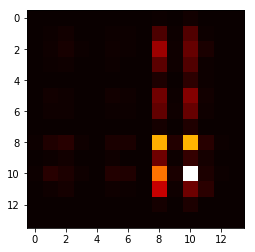

In [245]:
plt.imshow(cros, cmap='hot')
plt.show()

In [278]:
preds['texts'] = test['texts']

In [280]:
preds['diff'] = preds['predictions'] - preds['real']

In [290]:
righ_preds = preds[preds['diff'] == 0]

In [293]:
righ_preds = righ_preds.reset_index()

In [310]:
righ_preds.to_csv('right_preds.csv', index=False)

In [ ]:
top_freqs_clusters = pd.read_csv('/olgasilyutina/emoji_prediction/rf_classifier/top_freqs_clusters.csv')

In [298]:
pd.set_option('display.max_colwidth', -1)
righ_preds[righ_preds['index'] == 37035]['texts']

10587    Я в тюрьме всем нашим ауе здесь так плохо и одиноко лучше сюда непопадать здесь ломается моя жизнь😪 https://t.co/3SETIXDVjq
Name: texts, dtype: object

In [309]:
list(top_freqs_clusters[top_freqs_clusters['cluster_group'] == \
                   int(righ_preds[righ_preds['index'] == 37035]['predictions'])]['index'])

['😭', '😔', '😒', '😪', '😢']

In [312]:
len(list(zip(X_train, forest.feature_importances_)))

329

In [311]:
# View a list of the features and their importance scores
list(zip(X_train, forest.feature_importances_))

[('n_urls', 0.010006023902569416),
 ('n_hashtags', 0.002342969275623053),
 ('n_mentions', 0.016872582637639192),
 ('n_chars', 0.049012435954399934),
 ('n_commas', 0.014962293134684253),
 ('n_digits', 0.010939333500011505),
 ('n_exclaims', 0.00922302475123034),
 ('n_extraspaces', 0.014516981258473465),
 ('n_lowers', 0.049111187590186046),
 ('n_lowersp', 0.061709690149350266),
 ('n_periods', 0.012664062529740028),
 ('n_words', 0.041263024919267276),
 ('n_caps', 0.023641445925227635),
 ('n_nonasciis', 0.0704907439880744),
 ('n_puncts', 0.05816361334924332),
 ('n_capsp', 0.0483489138421192),
 ('n_charsperword', 0.05774002971005305),
 ('sent_afinn', 0.001252656079074329),
 ('sent_bing', 0.0012994973072617897),
 ('n_polite', 0.0013511509560665798),
 ('n_first_person', 0.00018453317416224747),
 ('n_first_personp', 6.574982593819727e-06),
 ('n_second_person', 6.423039788149194e-05),
 ('n_second_personp', 0.0008668465641100087),
 ('n_third_person', 3.8063732144696456e-06),
 ('n_tobe', 6.6177808